# 001_CWRK:Project Report
# 771762_C24_T1: Big Data and Data Mining

# Muhammad Huzaifa Owais

In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Connecting to database

In [2]:
con = sqlite3.connect("accident_data_v1.0.0_2023 (2).db")
cur = con.cursor()

## Tables in Database & their Shape

In [3]:
# Execute the query to get the table names
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all results
tables = cur.fetchall()

# Get the shape (rows and columns) of each table
table_shapes = {}
for table in tables:
    table_name = table[0]
    
    # Count the number of rows
    cur.execute(f"SELECT COUNT(*) FROM {table_name};")
    row_count = cur.fetchone()[0]
    
    # Count the number of columns
    cur.execute(f"PRAGMA table_info({table_name});")
    columns = cur.fetchall()
    column_count = len(columns)
    
    # Store the shape in the dictionary
    table_shapes[table_name] = (row_count, column_count)

# Print the table names and their shapes
for table, shape in table_shapes.items():
    print(f"Table '{table}' has shape {shape}")

Table 'accident' has shape (461352, 36)
Table 'casualty' has shape (600332, 19)
Table 'vehicle' has shape (849091, 28)
Table 'lsoa' has shape (34378, 7)


## Columns in Each Table

In [4]:
# Dictionary to store columns for each table
table_columns = {}

# Loop through each table and get its columns
for table in tables:
    table_name = table[0]
    
    # Get column information
    col_info = cur.execute(f"PRAGMA table_info({table_name})")
    columns = col_info.fetchall()
    
    # Extract column names
    column_names = [column[1] for column in columns]
    
    # Store column names in the dictionary with the table name as key
    table_columns[table_name] = column_names

# Print the column names for each table in the desired format
for table_name, columns in table_columns.items():
    print(f"{table_name.capitalize()}: {columns}")
    print()  

Accident: ['accident_index', 'accident_year', 'accident_reference', 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude', 'police_force', 'accident_severity', 'number_of_vehicles', 'number_of_casualties', 'date', 'day_of_week', 'time', 'local_authority_district', 'local_authority_ons_district', 'local_authority_highway', 'first_road_class', 'first_road_number', 'road_type', 'speed_limit', 'junction_detail', 'junction_control', 'second_road_class', 'second_road_number', 'pedestrian_crossing_human_control', 'pedestrian_crossing_physical_facilities', 'light_conditions', 'weather_conditions', 'road_surface_conditions', 'special_conditions_at_site', 'carriageway_hazards', 'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident', 'trunk_road_flag', 'lsoa_of_accident_location']

Casualty: ['casualty_index', 'accident_index', 'accident_year', 'accident_reference', 'vehicle_reference', 'casualty_reference', 'casualty_class', 'sex_of_casualty', 'age_of_casualty'

# DATA CLEANING

### 1) Cleaning 'location_easting_osgr', 'location_northing_osgr', 'longitude', 'latitude' Columns

Replacing nan entries with mode locations by looking at local_authority_district column

In [5]:
query1 = """
WITH ModeCalculations AS (
    SELECT 
        local_authority_district,
        -- Calculate the mode for location_easting_osgr
        (SELECT location_easting_osgr 
         FROM accident AS sub
         WHERE sub.local_authority_district = accident.local_authority_district 
           AND sub.location_easting_osgr IS NOT NULL
         GROUP BY location_easting_osgr
         ORDER BY COUNT(location_easting_osgr) DESC, location_easting_osgr ASC
         LIMIT 1) AS mode_location_easting,

        -- Calculate the mode for location_northing_osgr
        (SELECT location_northing_osgr 
         FROM accident AS sub
         WHERE sub.local_authority_district = accident.local_authority_district 
           AND sub.location_northing_osgr IS NOT NULL
         GROUP BY location_northing_osgr
         ORDER BY COUNT(location_northing_osgr) DESC, location_northing_osgr ASC
         LIMIT 1) AS mode_location_northing,

        -- Calculate the mode for longitude
        (SELECT longitude 
         FROM accident AS sub
         WHERE sub.local_authority_district = accident.local_authority_district 
           AND sub.longitude IS NOT NULL
         GROUP BY longitude
         ORDER BY COUNT(longitude) DESC, longitude ASC
         LIMIT 1) AS mode_longitude,

        -- Calculate the mode for latitude
        (SELECT latitude 
         FROM accident AS sub
         WHERE sub.local_authority_district = accident.local_authority_district 
           AND sub.latitude IS NOT NULL
         GROUP BY latitude
         ORDER BY COUNT(latitude) DESC, latitude ASC
         LIMIT 1) AS mode_latitude
    FROM accident
    GROUP BY local_authority_district
)
UPDATE accident
SET 
    location_easting_osgr = COALESCE(location_easting_osgr, (
        SELECT mode_location_easting 
        FROM ModeCalculations 
        WHERE ModeCalculations.local_authority_district = accident.local_authority_district
    )),
    location_northing_osgr = COALESCE(location_northing_osgr, (
        SELECT mode_location_northing 
        FROM ModeCalculations 
        WHERE ModeCalculations.local_authority_district = accident.local_authority_district
    )),
    longitude = COALESCE(longitude, (
        SELECT mode_longitude 
        FROM ModeCalculations 
        WHERE ModeCalculations.local_authority_district = accident.local_authority_district
    )),
    latitude = COALESCE(latitude, (
        SELECT mode_latitude 
        FROM ModeCalculations 
        WHERE ModeCalculations.local_authority_district = accident.local_authority_district
    ));
"""

#Execute the query
cur.execute(query1)
con.commit()

### 2) Cleaning local_authority_district column

2(a) local_authority_ons_district E07000244 (East Suffolk) & E07000245 (West Suffolk) are Suffolk Area which are formed in April 1, 2019. For most 2020 year, their local_authority_district data is registered as -1. Replacing all these -1 values with 37 that represent whole Suffolk.

In [6]:
query2_a = """
UPDATE accident
SET local_authority_district = 37
WHERE local_authority_district = -1
  AND local_authority_ons_district IN ('E07000244', 'E07000245');
"""
cur.execute(query2_a)
con.commit()

2(b) Replacing remaining -1 Values in local_authority_district column with function

In [7]:
query2_b = """
WITH ValidLocalAuthority AS (
    SELECT 
        a.local_authority_ons_district,
        a.local_authority_highway,
        a.local_authority_district
    FROM accident a
    WHERE a.local_authority_district != -1
)
UPDATE accident
SET local_authority_district = (
    SELECT v.local_authority_district
    FROM ValidLocalAuthority v
    WHERE v.local_authority_ons_district = accident.local_authority_ons_district
    AND v.local_authority_highway = accident.local_authority_highway
    LIMIT 1
)
WHERE local_authority_district = -1;
"""
cur.execute(query2_b)
con.commit()

### 3) Cleaning of local_authority_highway Column

Replaces -1 in the local_authority_highway column with the corresponding value from the local_authority_ons_district column

In [8]:
query3 = """
UPDATE accident
SET local_authority_highway = 
    CASE 
        WHEN local_authority_highway = '-1' THEN local_authority_ons_district
        ELSE local_authority_highway
    END;
"""
cur.execute(query3)
con.commit()


### 4) Cleaning speed_limit

Replacing -1 values in speed_limit with the mode of speed_limit of its local_authority_district

In [9]:
query4 = """
WITH ModeSpeedLimit AS (
    SELECT 
        local_authority_district,
        speed_limit,
        COUNT(*) AS frequency
    FROM accident
    WHERE speed_limit != -1
    GROUP BY local_authority_district, speed_limit
),
RankedModes AS (
    SELECT 
        local_authority_district,
        speed_limit,
        frequency,
        ROW_NUMBER() OVER (PARTITION BY local_authority_district ORDER BY frequency DESC) AS rank
    FROM ModeSpeedLimit
)
UPDATE accident
SET speed_limit = (
    SELECT speed_limit
    FROM RankedModes
    WHERE RankedModes.local_authority_district = accident.local_authority_district
    AND RankedModes.rank = 1
)
WHERE speed_limit = -1;
"""

cur.execute(query4)
con.commit()

### 5) Cleaning light_conditions Column

There's few -1 entries in this column, let first look at the entries. For ease, I am making dataframe to have a better inspection

In [10]:
df_accident = pd.read_sql_query("SELECT * FROM accident", con)

In [11]:
df_accident[df_accident["light_conditions"] == -1]

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
122679,201763D084717,2017,63D084717,311770.0,331000.0,-3.312181,52.869231,63,3,2,...,0,-1,-1,-1,-1,-1,2,1,-1,W01001907
370083,2019983103819,2019,983103819,296905.0,576133.0,-3.615979,55.068927,98,3,1,...,-1,-1,1,-1,-1,-1,1,2,-1,-1
449930,2020520002488,2020,520002488,343681.0,154706.0,-2.809007,51.288686,52,1,1,...,-1,-1,-1,-1,-1,-1,2,-1,2,E01029085


By looking at time we can predict that first two entries would be 1 (daylight), for last entry we can refer it as 7 (Darkness: street lighting unknown)`

In [12]:
query5a = """
UPDATE accident
SET light_conditions = 1
WHERE accident_index IN ('201763D084717', '2019983103819')
  AND light_conditions = -1;
"""

query5b = """
UPDATE accident
SET light_conditions = 7
WHERE accident_index = '2020520002488';
"""

# Execute both queries
cur.execute(query5a)
cur.execute(query5b)

con.commit()


### 6) Cleaning weather_conditions column

Replacing -1 with 9 (unknown)

In [13]:
query6 = """
UPDATE accident
SET weather_conditions = 9
WHERE weather_conditions = -1;
"""

# Execute the query
cur.execute(query6)

# Commit the changes
con.commit()

### 7) Cleaning road_surface_conditions column

Replacing -1 with 9 (unknown)

In [14]:
query7 = """
UPDATE accident
SET road_surface_conditions = 9
WHERE road_surface_conditions = -1;
"""

# Execute the query
cur.execute(query7)

# Commit the changes
con.commit()

### 8) Cleaning lsoa_of_accident_location column

Replacing -1 with unknown

In [15]:
query8 = """
UPDATE accident
SET lsoa_of_accident_location = "unknown"
WHERE lsoa_of_accident_location = "-1";
"""

# Execute the query
cur.execute(query8)

# Commit the changes
con.commit()

# TASKS

# 1. Are there significant hours of the day, and days of the week, on which accidents occur?

C:\Users\hp\AppData\Local\Temp\ipykernel_1448\362529681.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hours, y=accidents_by_hour, palette='viridis')


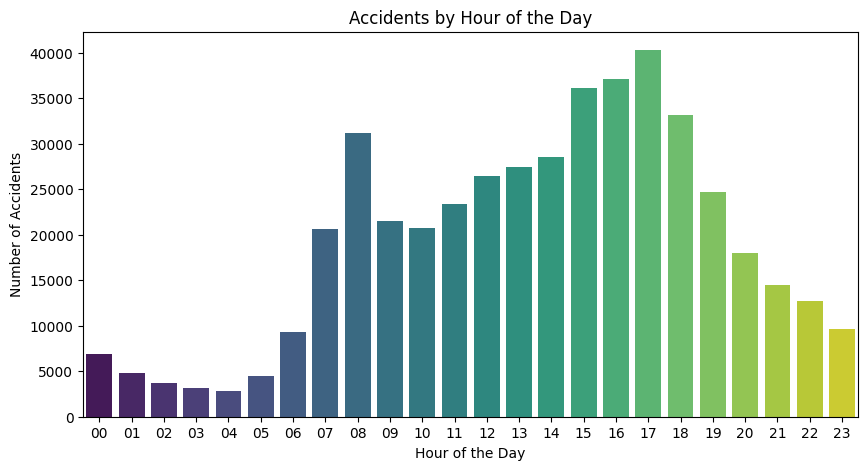

In [6]:
# Query for accidents by hour of the day
cur.execute("""
SELECT
    strftime('%H', 
        substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2) || ' ' || time
    ) AS hour,
    COUNT(*) AS num_accidents
FROM accident
WHERE date IS NOT NULL AND time IS NOT NULL
  AND date != '' AND time != ''
GROUP BY hour
ORDER BY hour;
""")
hourly_accidents = cur.fetchall()

# If you want to visualize it:
if hourly_accidents:
    hours, accidents_by_hour = zip(*hourly_accidents)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=hours, y=accidents_by_hour, palette='viridis')
    plt.title('Accidents by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24))
    plt.savefig('accidents_by_hour.png', dpi=300)
    plt.show()
else:
    print("No data available for accidents by hour.")


C:\Users\hp\AppData\Local\Temp\ipykernel_1448\4186319881.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days, y=accidents_by_day, palette='coolwarm')


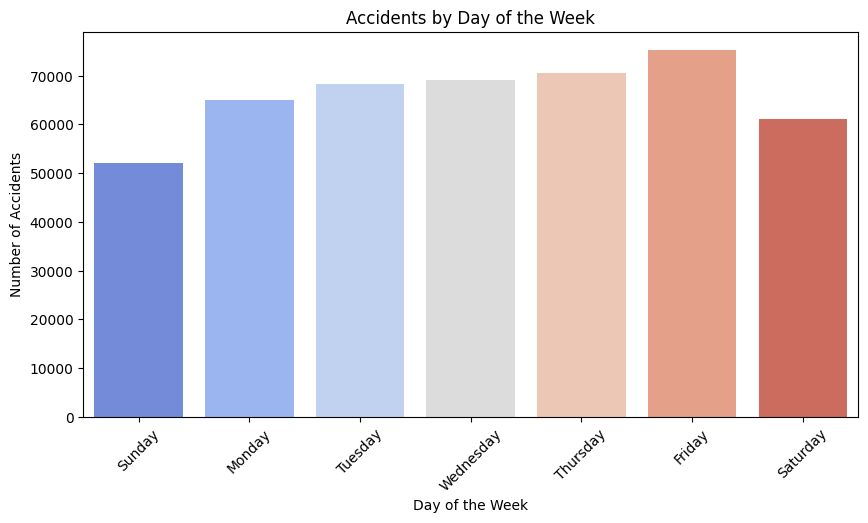

In [7]:
# Query for accidents by day of the week
cur.execute("""
SELECT
    CASE
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '0' THEN 'Sunday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '1' THEN 'Monday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '2' THEN 'Tuesday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '3' THEN 'Wednesday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '4' THEN 'Thursday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '5' THEN 'Friday'
        WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '6' THEN 'Saturday'
    END AS day_of_week,
    COUNT(*) AS num_accidents
FROM accident
WHERE date IS NOT NULL AND time IS NOT NULL
  AND date != '' AND time != ''
GROUP BY day_of_week
ORDER BY CASE 
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '0' THEN 1
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '1' THEN 2
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '2' THEN 3
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '3' THEN 4
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '4' THEN 5
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '5' THEN 6
             WHEN strftime('%w', substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2)) = '6' THEN 7
         END;
""")
weekday_accidents = cur.fetchall()

# If you want to visualize it:
if weekday_accidents:
    days, accidents_by_day = zip(*weekday_accidents)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=days, y=accidents_by_day, palette='coolwarm')
    plt.title('Accidents by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)
    plt.savefig('accidents_by_day.png', dpi=300)
    plt.show()
else:
    print("No data available for accidents by day of the week.")


# 2. For motorbikes, are there significant hours of the day, and days of the week, on which accidents occur? We suggest a focus on: Motorcycle 125cc and under, Motorcycle over 125cc and up to 500cc, and Motorcycle over 500cc.


C:\Users\hp\AppData\Local\Temp\ipykernel_1448\2407210559.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hours, y=accidents_by_hour, palette='viridis')


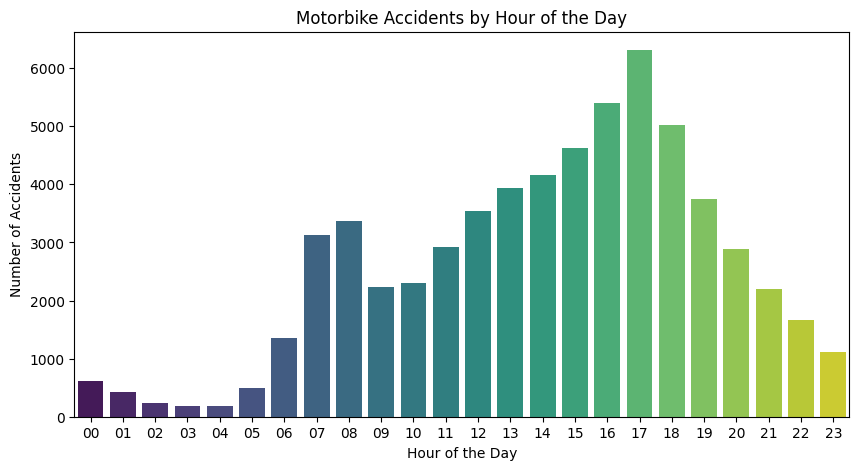

In [8]:
# Query for significant hours of the day for motorcycles
cur.execute("""
SELECT
    strftime('%H', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2) || ' ' || accident.time) AS hour,
    COUNT(*) AS num_accidents
FROM accident
JOIN vehicle ON accident.accident_reference = vehicle.accident_reference
WHERE vehicle.vehicle_type IN (3, 4, 5)  -- Filter for motorcycles: 125cc & under (3), 125cc-500cc (4), and over 500cc (5)
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY hour
ORDER BY hour;
""")
hourly_motorbike_accidents = cur.fetchall()

# Check if there is data
if hourly_motorbike_accidents:
    # Unpack the results into hours and accident counts
    hours, accidents_by_hour = zip(*hourly_motorbike_accidents)
    
    # Plotting the accidents by hour
    plt.figure(figsize=(10, 5))
    sns.barplot(x=hours, y=accidents_by_hour, palette='viridis')
    plt.title('Motorbike Accidents by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24))  # Display all hours from 0 to 23
    plt.savefig('Motorbikeaccidents_by_hour.png', dpi=300)
    plt.show()
else:
    print("No data available for accidents by hour.")


C:\Users\hp\AppData\Local\Temp\ipykernel_1448\3242901014.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days, y=accidents_by_day, palette='coolwarm')


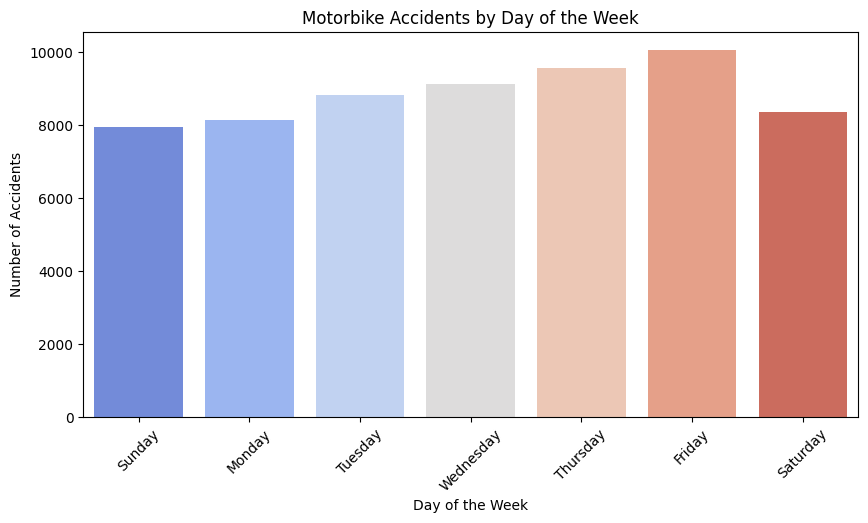

In [9]:
# Query for significant days of the week for motorcycles
cur.execute("""
SELECT
    CASE
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 'Sunday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 'Monday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 'Tuesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 'Wednesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 'Thursday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 'Friday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 'Saturday'
    END AS day_of_week,
    COUNT(*) AS num_accidents
FROM accident
JOIN vehicle ON accident.accident_reference = vehicle.accident_reference
WHERE vehicle.vehicle_type IN (3, 4, 5)  -- Filter for motorcycles: 125cc & under (3), 125cc-500cc (4), and over 500cc (5)
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY day_of_week
ORDER BY CASE
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 1
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 2
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 3
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 4
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 5
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 6
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 7
         END;
""")
weekday_motorbike_accidents = cur.fetchall()

# Check if there is data
if weekday_motorbike_accidents:
    # Unpack the results into days and accident counts
    days, accidents_by_day = zip(*weekday_motorbike_accidents)
    
    # Plotting the accidents by day of the week
    plt.figure(figsize=(10, 5))
    sns.barplot(x=days, y=accidents_by_day, palette='coolwarm')
    plt.title('Motorbike Accidents by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)  # Rotate the days for better visibility
    plt.savefig('Motorbikeaccidents_by_day.png', dpi=300)
    plt.show()
else:
    print("No data available for accidents by day of the week.")


# 3. For pedestrians involved in accidents, are there significant hours of the day, and days of the week, on which they are more likely to be involved?

C:\Users\hp\AppData\Local\Temp\ipykernel_1448\2173710332.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hours, y=accidents_by_hour, palette='viridis')


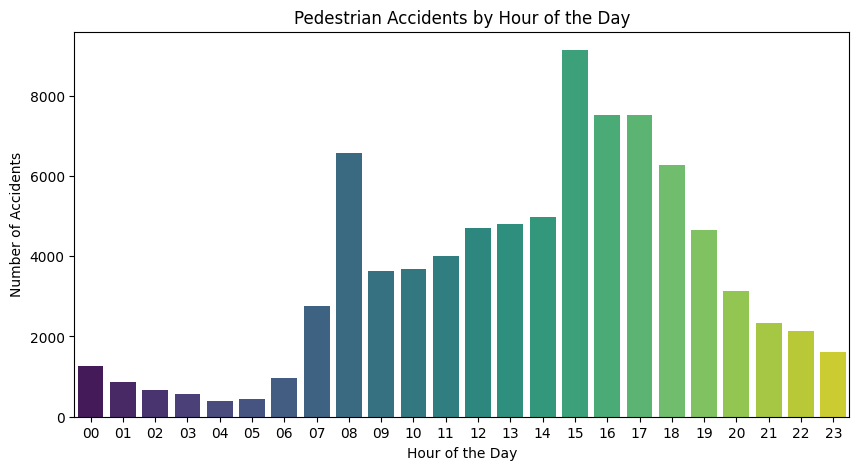

In [10]:
# Query for accidents by hour of the day involving pedestrians
cur.execute("""
SELECT
    strftime('%H', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2) || ' ' || accident.time) AS hour,
    COUNT(*) AS num_accidents
FROM accident
JOIN casualty ON accident.accident_reference = casualty.accident_reference
WHERE casualty.casualty_class = 3  -- Filter for pedestrians
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY hour
ORDER BY hour;
""")
hourly_pedestrian_accidents = cur.fetchall()

# Check if there is data and plot
if hourly_pedestrian_accidents:
    # Unpack the results into hours and accident counts
    hours, accidents_by_hour = zip(*hourly_pedestrian_accidents)
    
    # Plotting the accidents by hour
    plt.figure(figsize=(10, 5))
    sns.barplot(x=hours, y=accidents_by_hour, palette='viridis')
    plt.title('Pedestrian Accidents by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Accidents')
    plt.xticks(range(0, 24))  # Display all hours from 0 to 23
    plt.savefig('Pedestrianaccidents_by_hour.png', dpi=300)
    plt.show()
else:
    print("No data available for pedestrian accidents by hour.")


C:\Users\hp\AppData\Local\Temp\ipykernel_1448\1797284170.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=days, y=accidents_by_day, palette='coolwarm')


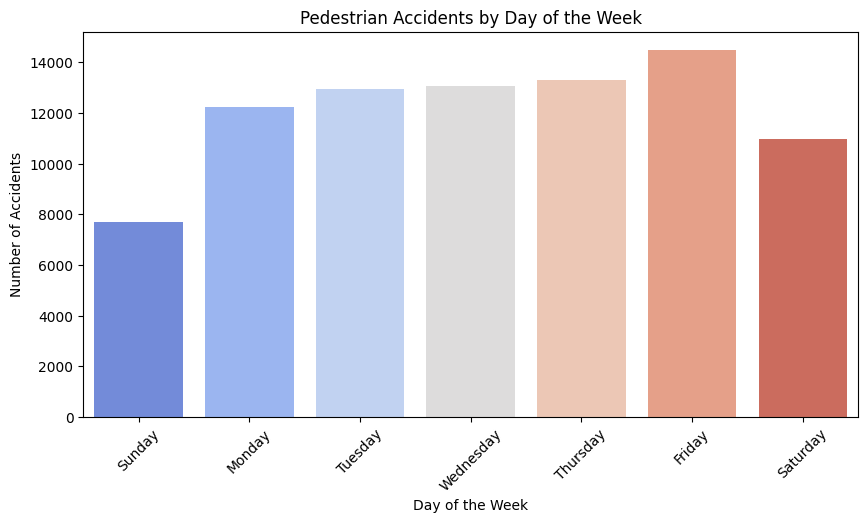

In [11]:
# Query for accidents by day of the week involving pedestrians
cur.execute("""
SELECT
    CASE
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 'Sunday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 'Monday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 'Tuesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 'Wednesday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 'Thursday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 'Friday'
        WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 'Saturday'
    END AS day_of_week,
    COUNT(*) AS num_accidents
FROM accident
JOIN casualty ON accident.accident_reference = casualty.accident_reference
WHERE casualty.casualty_class = 3  -- Filter for pedestrians
    AND accident.date IS NOT NULL AND accident.time IS NOT NULL
GROUP BY day_of_week
ORDER BY CASE
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '0' THEN 1
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '1' THEN 2
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '2' THEN 3
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '3' THEN 4
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '4' THEN 5
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '5' THEN 6
            WHEN strftime('%w', substr(accident.date, 7, 4) || '-' || substr(accident.date, 4, 2) || '-' || substr(accident.date, 1, 2)) = '6' THEN 7
         END;
""")
weekday_pedestrian_accidents = cur.fetchall()

# Check if there is data and plot
if weekday_pedestrian_accidents:
    # Unpack the results into days and accident counts
    days, accidents_by_day = zip(*weekday_pedestrian_accidents)
    
    # Plotting the accidents by day of the week
    plt.figure(figsize=(10, 5))
    sns.barplot(x=days, y=accidents_by_day, palette='coolwarm')
    plt.title('Pedestrian Accidents by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Accidents')
    plt.xticks(rotation=45)  # Rotate the days for better visibility
    plt.savefig('Pedestrianaccidents_by_day.png', dpi=300)
    plt.show()
else:
    print("No data available for pedestrian accidents by day of the week.")


# 4. Using the apriori algorithm, explore the impact of selected variables on accident severity.

### I will be looking at the impact of speed_limit, weather_conditions, road_surface_condition, light_conditions & vehicle_type on accident_severity

First lets make dataframe

In [12]:
df_accident = pd.read_sql_query("SELECT * FROM accident", con)

In [13]:
def encode_and_select_columns(df, columns_to_encode):
    """
    Function to apply one-hot encoding to specified columns
    and return a new dataframe with only the encoded columns.
    """
    
    encoded_columns = []  #List to hold encoded columns
    
    # Apply one-hot encoding for each column in the list
    for column in columns_to_encode:
        dummies = pd.get_dummies(df[column], prefix=column).astype(int)
        
        # Append the encoded columns to the list
        encoded_columns.append(dummies)
    
    # Concatenate all the encoded columns into a single dataframe
    encoded_df = pd.concat(encoded_columns, axis=1)
    
    return encoded_df

In [14]:
columns_to_encode = ["accident_severity", "speed_limit", "weather_conditions", "road_surface_conditions", "light_conditions"]

# Apply the function
encoded_df = encode_and_select_columns(df_accident, columns_to_encode)
encoded_df.head()

,accident_severity_1,accident_severity_2,accident_severity_3,speed_limit_20,speed_limit_30,speed_limit_40,speed_limit_50,speed_limit_60,speed_limit_70,weather_conditions_1,...,road_surface_conditions_2,road_surface_conditions_3,road_surface_conditions_4,road_surface_conditions_5,road_surface_conditions_9,light_conditions_1,light_conditions_4,light_conditions_5,light_conditions_6,light_conditions_7
0,1,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,1,0,1,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0
2,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
4,0,1,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,0


In [15]:
from mlxtend.frequent_patterns import apriori, association_rules
freq_item_sets = apriori(encoded_df, min_support=0.2, use_colnames=True)
freq_item_sets.head()

C:\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.798299,(accident_severity_3)
1,0.595422,(speed_limit_30)
2,0.795436,(weather_conditions_1)
3,0.711372,(road_surface_conditions_1)
4,0.258540,(road_surface_conditions_2)


In [16]:
rules = association_rules(freq_item_sets, metric="lift", min_threshold = 0.5 ).sort_values(by='lift', ascending=False)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
157,"(weather_conditions_1, light_conditions_1, spe...","(road_surface_conditions_1, accident_severity_3)",0.357582,0.567682,0.263627,0.737251,1.298705,0.060635,1.645366,0.358026
176,"(road_surface_conditions_1, accident_severity_3)","(weather_conditions_1, light_conditions_1, spe...",0.567682,0.357582,0.263627,0.464393,1.298705,0.060635,1.199421,0.532020
164,"(weather_conditions_1, light_conditions_1, acc...","(road_surface_conditions_1, speed_limit_30)",0.477499,0.435414,0.263627,0.552101,1.267991,0.055718,1.260520,0.404498
169,"(road_surface_conditions_1, speed_limit_30)","(weather_conditions_1, light_conditions_1, acc...",0.435414,0.477499,0.263627,0.605464,1.267991,0.055718,1.324344,0.374346
153,"(weather_conditions_1, light_conditions_1, spe...",(road_surface_conditions_1),0.294010,0.711372,0.263627,0.896662,1.260468,0.054477,2.793040,0.292701


In [17]:
accident_severity_rules = rules[rules['consequents'].apply(lambda x: any('accident_severity' in str(item) for item in x))]
accident_severity_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
157,"(weather_conditions_1, light_conditions_1, spe...","(road_surface_conditions_1, accident_severity_3)",0.357582,0.567682,0.263627,0.737251,1.298705,0.060635,1.645366,0.358026
169,"(road_surface_conditions_1, speed_limit_30)","(weather_conditions_1, light_conditions_1, acc...",0.435414,0.477499,0.263627,0.605464,1.267991,0.055718,1.324344,0.374346
180,(road_surface_conditions_1),"(weather_conditions_1, light_conditions_1, spe...",0.711372,0.294010,0.263627,0.370590,1.260468,0.054477,1.121670,0.715952
129,"(weather_conditions_1, light_conditions_1)","(road_surface_conditions_1, accident_severity_3)",0.595608,0.567682,0.421630,0.707899,1.247000,0.083515,1.480030,0.489811
171,"(weather_conditions_1, light_conditions_1)","(road_surface_conditions_1, speed_limit_30, ac...",0.595608,0.355893,0.263627,0.442619,1.243685,0.051655,1.155595,0.484524


C:\Users\hp\AppData\Local\Temp\ipykernel_1448\2962516331.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lift', y='antecedents', data=accident_severity_rules.head(10), palette='viridis')


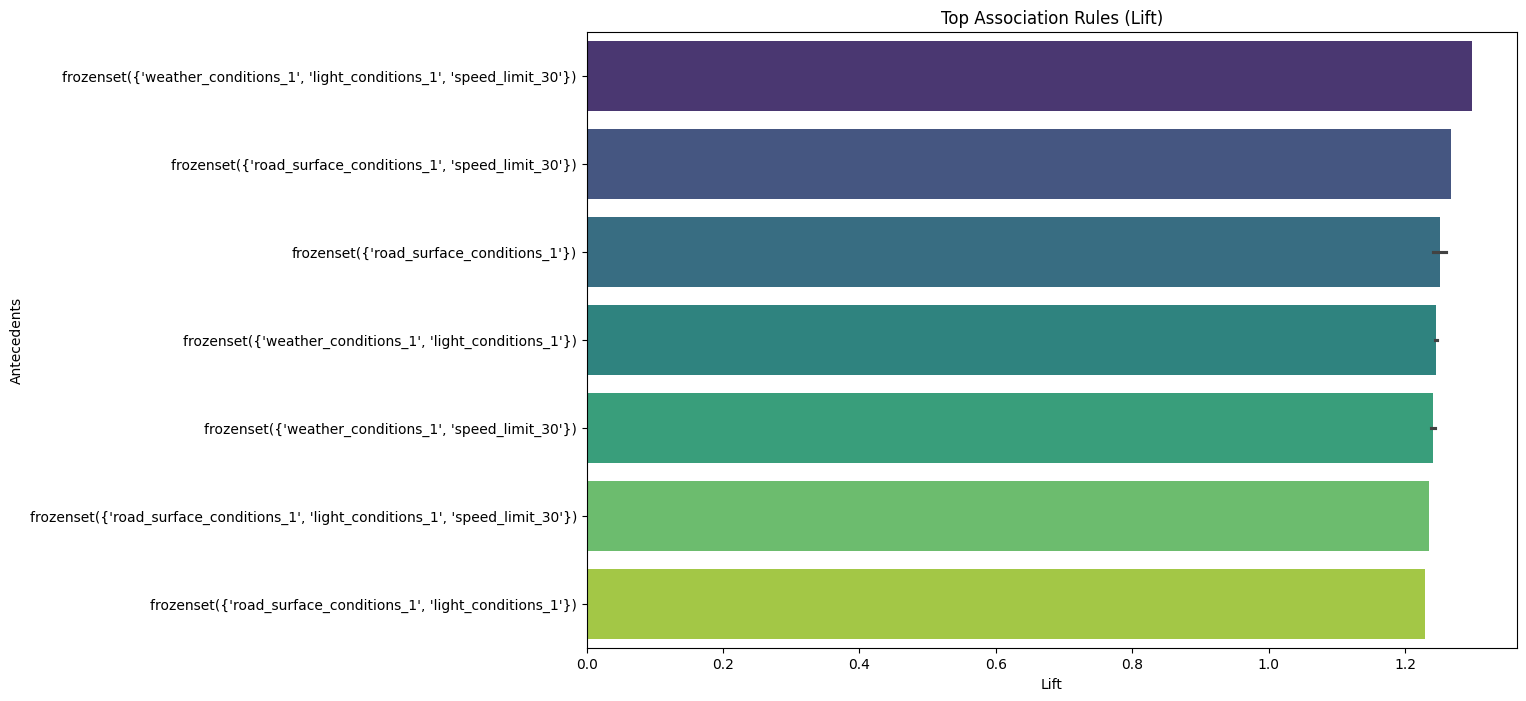

In [18]:
# Plotting top rules based on lift
plt.figure(figsize=(12, 8))
sns.barplot(x='lift', y='antecedents', data=accident_severity_rules.head(10), palette='viridis')
plt.title('Top Association Rules (Lift)')
plt.xlabel('Lift')
plt.ylabel('Antecedents')
plt.savefig('Top Association Rules (Lift)', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_1448\3958180360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_rules['accident_severity'] = filtered_rules['consequents'].apply(
C:\Users\hp\AppData\Local\Temp\ipykernel_1448\3958180360.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


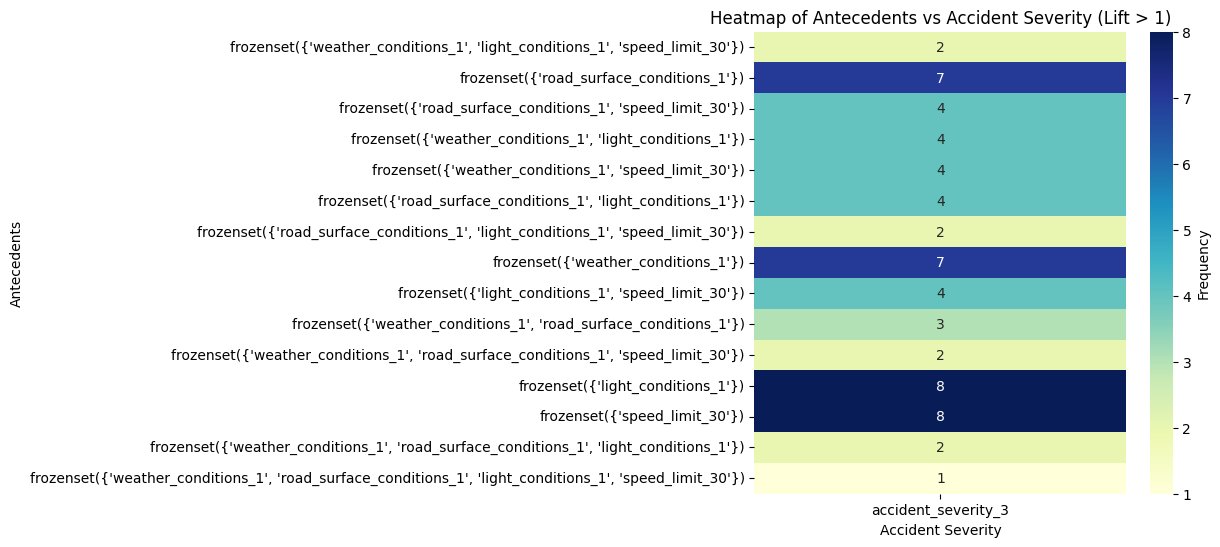

In [19]:
# Filter rules to include only lift > 1
filtered_rules = accident_severity_rules[accident_severity_rules['lift'] > 1]

# Extract 'accident_severity' from the 'consequents' and add it to the filtered dataframe
filtered_rules['accident_severity'] = filtered_rules['consequents'].apply(
    lambda x: [item for item in x if 'accident_severity' in str(item)][0] if isinstance(x, frozenset) else None
)

# Create a pivot table for visualization
heatmap_data = filtered_rules.groupby(['antecedents', 'accident_severity']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="d", cbar_kws={'label': 'Frequency'})
plt.title('Heatmap of Antecedents vs Accident Severity (Lift > 1)')
plt.xlabel('Accident Severity')
plt.ylabel('Antecedents')
plt.tight_layout()
plt.savefig('Heatmap_Antecedents_vs_Accident_Severity_Lift_1.png', dpi=300, bbox_inches='tight')
plt.show()

The heatmap will help visualize the frequency of antecedents associated with each accident severity. It will show which antecedents are strongly linked to each severity level (e.g., slight, serious, fatal).

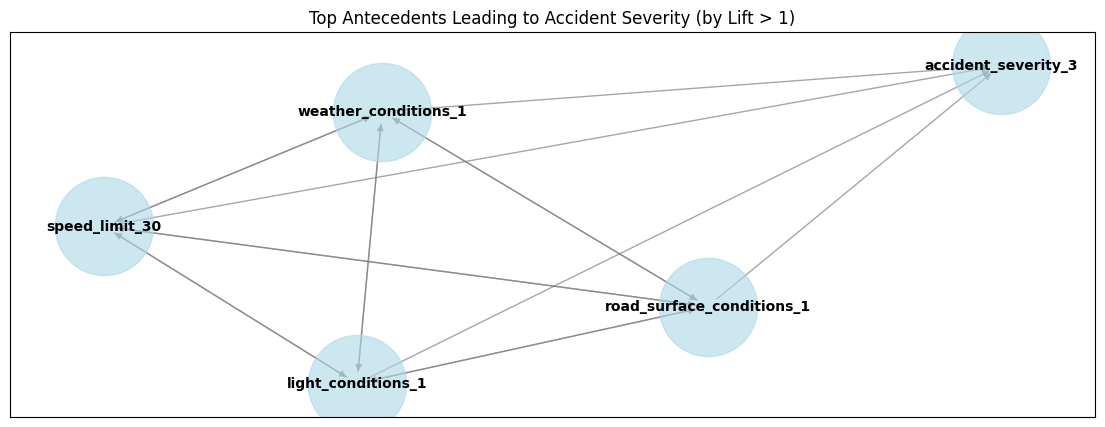

In [20]:
import networkx as nx

# Filter rules to include only lift > 1
filtered_rules = accident_severity_rules[accident_severity_rules['lift'] > 1]

# Create a directed graph
G = nx.DiGraph()

# Add edges from the antecedents to the consequents
for index, row in filtered_rules.iterrows():
    antecedents = list(row['antecedents'])
    consequent = list(row['consequents'])[0]  # Only one consequent, accident severity
    for antecedent in antecedents:
        G.add_edge(antecedent, consequent, weight=row['lift'])

# Plotting
plt.figure(figsize=(14, 5))
pos = nx.spring_layout(G, seed=42)  # Use spring layout for better visualization
nx.draw_networkx_nodes(G, pos, node_size=5000, node_color="lightblue", alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='black')
plt.title('Top Antecedents Leading to Accident Severity (by Lift > 1)')
plt.savefig('Top Antecedents Leading to Accident Severity by lift_1', dpi=300)
plt.show()

This graph shows a network of antecedents (e.g., weather conditions, speed limit) leading to accident severity. The edges between nodes are weighted by lift, showing how strong the association is between the antecedent and the severity.

# 5. Identify accidents in our region: Kingston upon Hull, Humberside, and the East Riding of Yorkshire etc. You can do this by filtering on LSOA, or police region or another method if you can find one. Run clustering on this data. What do these clusters reveal about the distribution of accidents in our region?

### HUMBER SIDE:
#### kingston upon hull = E01012756 to E01012918
#### East Riding of Yorkshire = E01012919 to E01013127
#### North Lincolnshire = E01013235 to E01013334
#### North East Lincolnshire = E01013128 to E01013234

In [5]:
query = """
SELECT *
FROM accident
WHERE (lsoa_of_accident_location >= 'E01012756' AND lsoa_of_accident_location <= 'E01012918') 
   OR (lsoa_of_accident_location >= 'E01012919' AND lsoa_of_accident_location <= 'E01013127')
   OR (lsoa_of_accident_location >= 'E01013235' AND lsoa_of_accident_location <= 'E01013334')
   OR (lsoa_of_accident_location >= 'E01013128' AND lsoa_of_accident_location <= 'E01013234');
"""

# Execute the query and fetch the results
df_region = pd.read_sql_query(query, con)

In [6]:
# Add region labels based on the LSOA codes
def label_region(lsoa_code):
    if 'E01012756' <= lsoa_code <= 'E01012918':  # Kingston upon Hull
        return 'Kingston upon Hull'
    elif 'E01012919' <= lsoa_code <= 'E01013127':  # East Riding of Yorkshire
        return 'East Riding of Yorkshire'
    elif 'E01013235' <= lsoa_code <= 'E01013334':  # North Lincolnshire
        return 'North Lincolnshire'
    elif 'E01013128' <= lsoa_code <= 'E01013234':  # North East Lincolnshire
        return 'North East Lincolnshire'
    else:
        return 'Other'

# Apply the function to create a new 'region' column
df_region['region'] = df_region['lsoa_of_accident_location'].apply(label_region)

In [7]:
# Calculate the count of accidents by region
region_counts = df_region['region'].value_counts()

C:\Users\hp\AppData\Local\Temp\ipykernel_120\2639885070.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=region_counts.index, y=region_counts.values, palette='Set2')


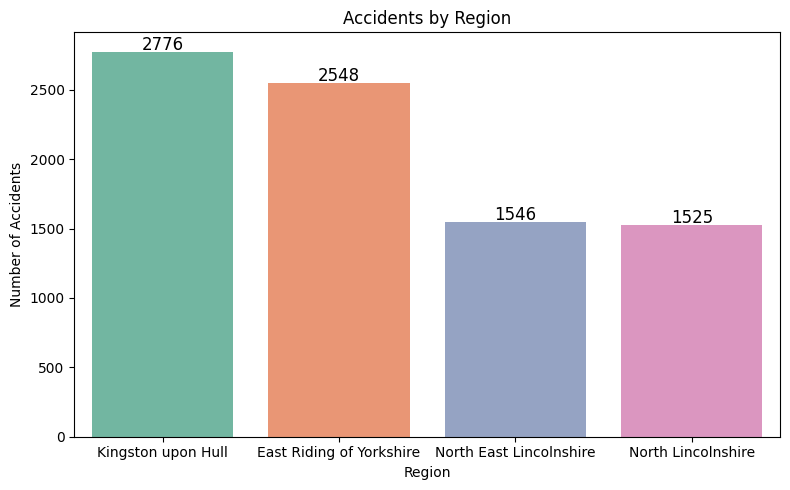

In [8]:
# Plot a bar chart for the counts of accidents by region
plt.figure(figsize=(8, 5))
ax = sns.barplot(x=region_counts.index, y=region_counts.values, palette='Set2')

# Add count annotations on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                fontsize=12, color='black', 
                xytext=(0, 5), textcoords='offset points')

# Set title and labels
plt.title('Accidents by Region')
plt.xlabel('Region')
plt.ylabel('Number of Accidents')

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('Accidents by Region', dpi=300, bbox_inches='tight')
plt.show()

## a) Geographical Clustering

In [9]:
lat_lon = df_region[['longitude','latitude']]

In [10]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

cluster_range = range(10, 101, 10)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette score for each cluster count
for n_clusters in cluster_range:
    Geo_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    Geo_kmeans.fit(lat_lon)
    
    # Append inertia
    inertia_values.append(Geo_kmeans.inertia_)
    
    # Calculate silhouette score 
    silhouette_avg = silhouette_score(lat_lon, Geo_kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

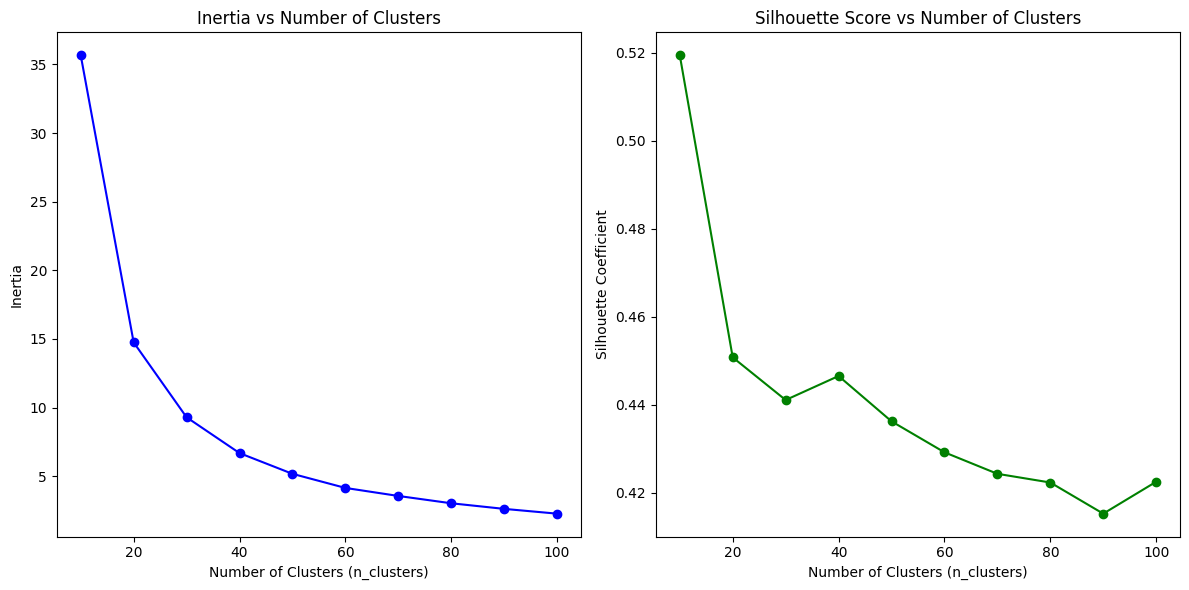

In [11]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')  
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

Elbow is observed at n = 20 and it's corresponding Silhouette score is better, so choosing n = 20

In [12]:
Geo_kmeans = KMeans(n_clusters=20, random_state=42)

df_region['Geo_Clusters'] = Geo_kmeans.fit_predict(lat_lon)

print("Cluster Centers:")
print(Geo_kmeans.cluster_centers_)

Cluster Centers:
[[-0.65729871 53.58467023]
 [-0.28293334 53.76309072]
 [-0.22863501 53.61057751]
 [-0.46604792 54.02128271]
 [-0.10827379 53.55424847]
 [-0.87092535 53.72974079]
 [-0.21115647 54.08597984]
 [-0.44395778 53.84264351]
 [-0.40953776 53.74625224]
 [-0.54516347 53.53923523]
 [-0.81142127 53.93959138]
 [-0.35352298 53.76227102]
 [-0.07987508 53.7400019 ]
 [-0.64932601 53.8115421 ]
 [-0.82673782 53.54605402]
 [-0.05847844 53.55962335]
 [-0.99990076 53.68546162]
 [-0.48111584 53.71312522]
 [-0.39961454 53.59939333]
 [-0.24601902 53.90618725]]


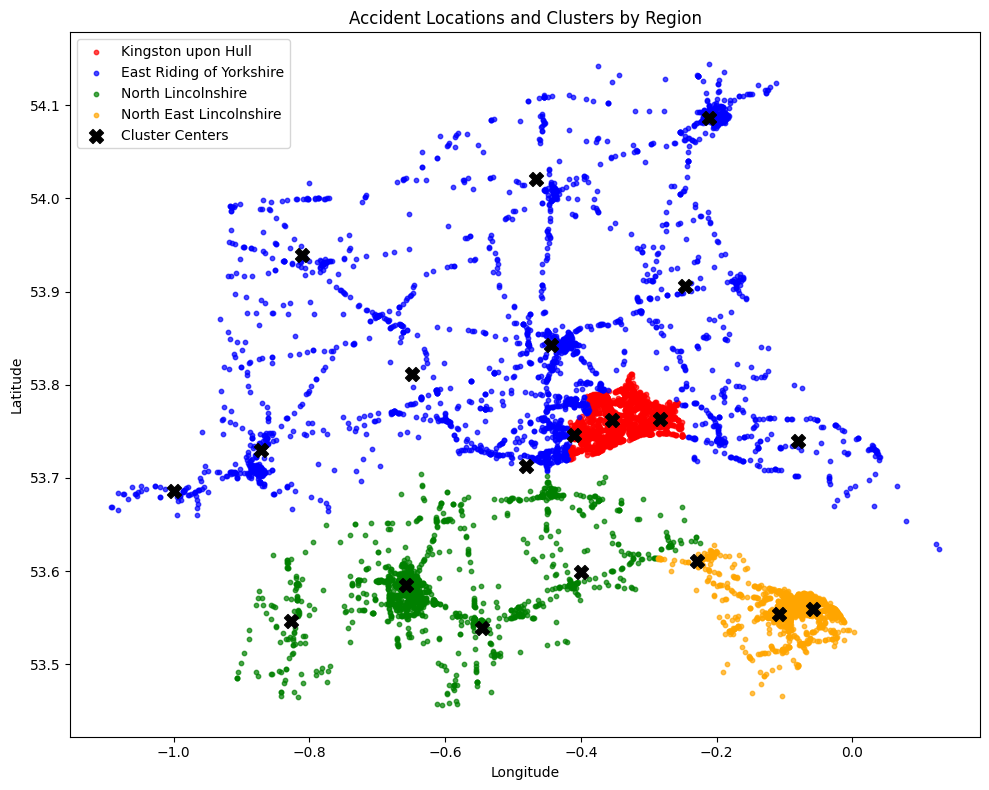

In [13]:
# Define colors for each region
region_colors = {
    'Kingston upon Hull': 'red',
    'East Riding of Yorkshire': 'blue',
    'North Lincolnshire': 'green',
    'North East Lincolnshire': 'orange'
}

# Map each region to its corresponding color
df_region['region_color'] = df_region['region'].map(region_colors)

# Plot size
plt.figure(figsize=(10, 8))

# Scatter plot 
for region, color in region_colors.items():
    region_data = df_region[df_region['region'] == region]
    plt.scatter(region_data['longitude'], region_data['latitude'], 
                c=color, s=10, alpha=0.7, label=region)

# Adding cluster centers for reference
Geo_cluster_centers = Geo_kmeans.cluster_centers_
plt.scatter(Geo_cluster_centers[:, 0], Geo_cluster_centers[:, 1], c='black', marker='X', s=100, label='Cluster Centers')

# Plotting
plt.title('Accident Locations and Clusters by Region')
plt.xlabel('Longitude') 
plt.ylabel('Latitude')
plt.legend(loc='upper left')  
plt.tight_layout()
plt.savefig('Accident Locations and Clusters by Region', dpi=300, bbox_inches='tight')
plt.show()

## b) Weather Condition & Road Surface Conditions Clustering

In [14]:
weather_road = df_region[['weather_conditions','road_surface_conditions']]

In [15]:
cluster_range = range(2, 16, 1)
inertia_values = []
silhouette_scores = []

# Compute inertia and silhouette score for each cluster count
for n_clusters in cluster_range:
    weatherroad_kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    weatherroad_kmeans.fit(weather_road)
    
    # Append inertia
    inertia_values.append(weatherroad_kmeans.inertia_)
    
    # Calculate silhouette score 
    silhouette_avg = silhouette_score(weather_road, weatherroad_kmeans.labels_)
    silhouette_scores.append(silhouette_avg)

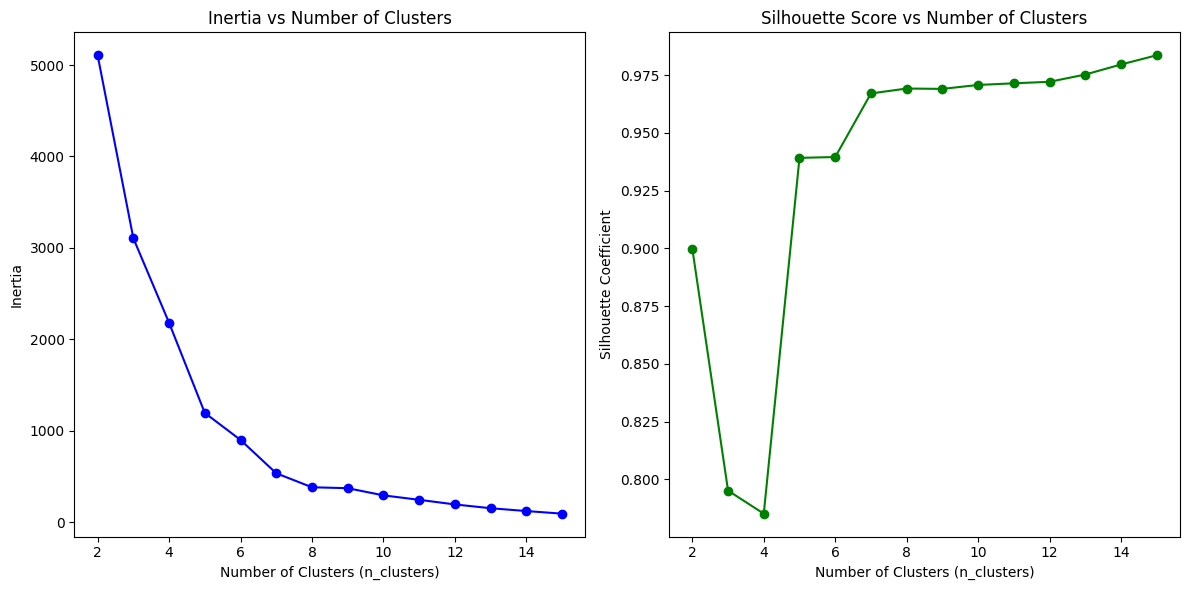

In [16]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot Inertia
plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Inertia')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')  
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters (n_clusters)')
plt.ylabel('Silhouette Coefficient')

plt.tight_layout()
plt.show()

Elbow is observed at n = 10 and it's corresponding Silhouette score is better, so choosing n = 10

Cluster Centers:
[[1.00267201 1.        ]
 [9.         2.22222222]
 [1.         2.00089767]
 [4.72380952 2.12380952]
 [2.02723147 2.01815431]
 [7.92307692 4.23076923]
 [1.17582418 4.12087912]
 [7.77241379 1.69655172]
 [9.         1.        ]
 [4.01298701 1.        ]]


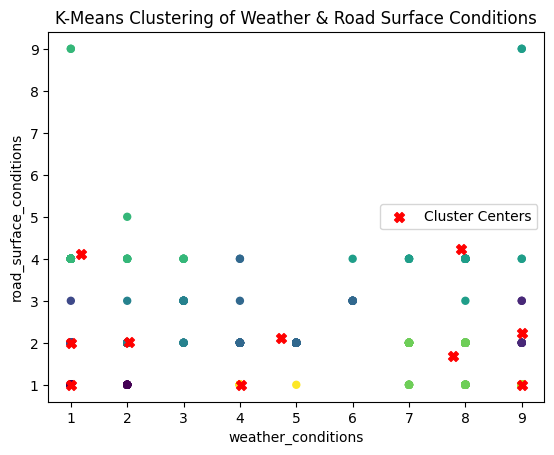

In [17]:
weatherroad_kmeans = KMeans(n_clusters=10, random_state=42)

df_region['weather_road_Clusters'] = weatherroad_kmeans.fit_predict(weather_road)

print("Cluster Centers:")
print(weatherroad_kmeans.cluster_centers_)

# Create a scatter plot
plt.scatter(df_region['weather_conditions'], df_region['road_surface_conditions'], c=df_region['weather_road_Clusters'], s=25)

# Adding cluster centers for reference
weatherroad_cluster_centers = weatherroad_kmeans.cluster_centers_
plt.scatter(weatherroad_cluster_centers[:, 0], weatherroad_cluster_centers[:, 1], c='red', marker='X', s=50, label='Cluster Centers')

# Plot settings
plt.title('K-Means Clustering of Weather & Road Surface Conditions')
plt.xlabel('weather_conditions') 
plt.ylabel('road_surface_conditions')  
plt.legend()
plt.savefig('K-Means Clustering of Weather & Road Surface Conditions', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\hp\AppData\Local\Temp\ipykernel_120\3924963139.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index + 1, y=cluster_counts.values, palette='viridis')  # Adding 1 to the index for cluster numbering


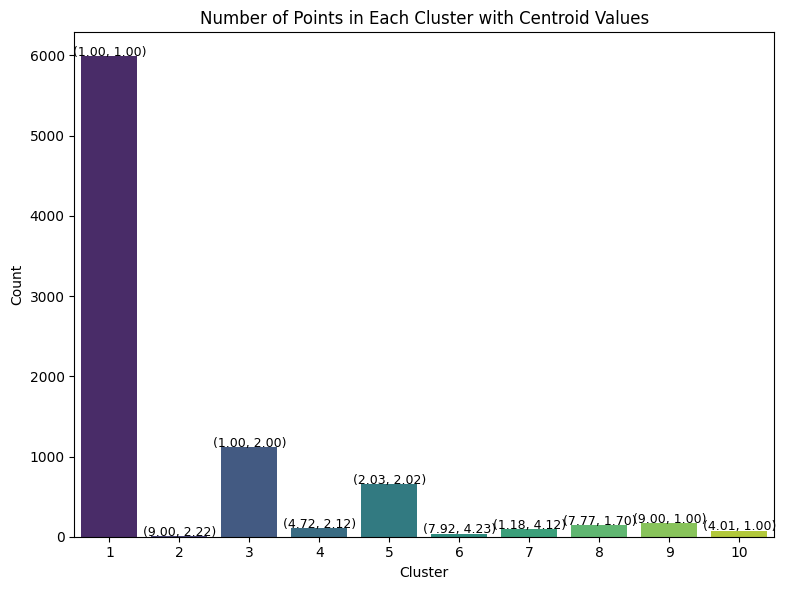

In [18]:
# Count the number of points in each cluster
cluster_counts = df_region['weather_road_Clusters'].value_counts().sort_index()

# Extract centroid values for light_conditions and road_surface_conditions
centroid_values = weatherroad_kmeans.cluster_centers_

# Create a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=cluster_counts.index + 1, y=cluster_counts.values, palette='viridis')  # Adding 1 to the index for cluster numbering

# Annotate each bar with its centroid values
for i, count in enumerate(cluster_counts):
    centroid_text = f"({centroid_values[i][0]:.2f}, {centroid_values[i][1]:.2f})"
    plt.text(i, count + 2, centroid_text, ha='center', fontsize=9, color='black')

# Plot settings
plt.title('Number of Points in Each Cluster with Centroid Values')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('Number of Points in Each Cluster with Centroid Values', dpi=300, bbox_inches='tight')
plt.show()

# 6. Choose three policing areas by filtering the data using the "police_force" column, then create time series models to predict weekly accident counts for the upcoming year based on historical data from 2017 to 2019.

City of London = 48, Greater Manchester = 6, Humberside = 16

In [19]:
query = """
SELECT 
    accident_reference,
    date,
    police_force
FROM accident
WHERE police_force IN (48, 6, 16)
    AND date BETWEEN '01/01/2017' AND '31/12/2019';
"""

# Execute the query and load the results into a pandas DataFrame
df_policing_areas = pd.read_sql_query(query, con)

# Convert 'date' column from day/month/year format to datetime
df_policing_areas['date'] = pd.to_datetime(df_policing_areas['date'], format='%d/%m/%Y')

# Extract year and ISO week number
df_policing_areas['year'] = df_policing_areas['date'].dt.year
df_policing_areas['week'] = df_policing_areas['date'].dt.isocalendar().week

# Group by year and week to get weekly accident counts
weekly_accidents = df_policing_areas.groupby(['year', 'week']).size().reset_index(name='accident_count')

# Recreate the date index for the first day of each ISO week
weekly_accidents['date'] = pd.to_datetime(weekly_accidents['year'].astype(str) + weekly_accidents['week'].astype(str) + '1', format='%G%V%w')

# Ensure the resulting dataframe aligns with your dataset range
weekly_accidents = weekly_accidents[(weekly_accidents['date'] >= '2017-01-01') & (weekly_accidents['date'] <= '2020-12-31')]

# Set the datetime index
weekly_accidents = weekly_accidents.set_index('date')

In [20]:
weekly_accidents = weekly_accidents.drop(columns=['year', 'week'])

In [21]:
weekly_accidents.head()

,accident_count
date,
2017-01-02,108
2017-01-09,110
2017-01-16,101
2017-01-23,122
2017-01-30,131


## Visualising

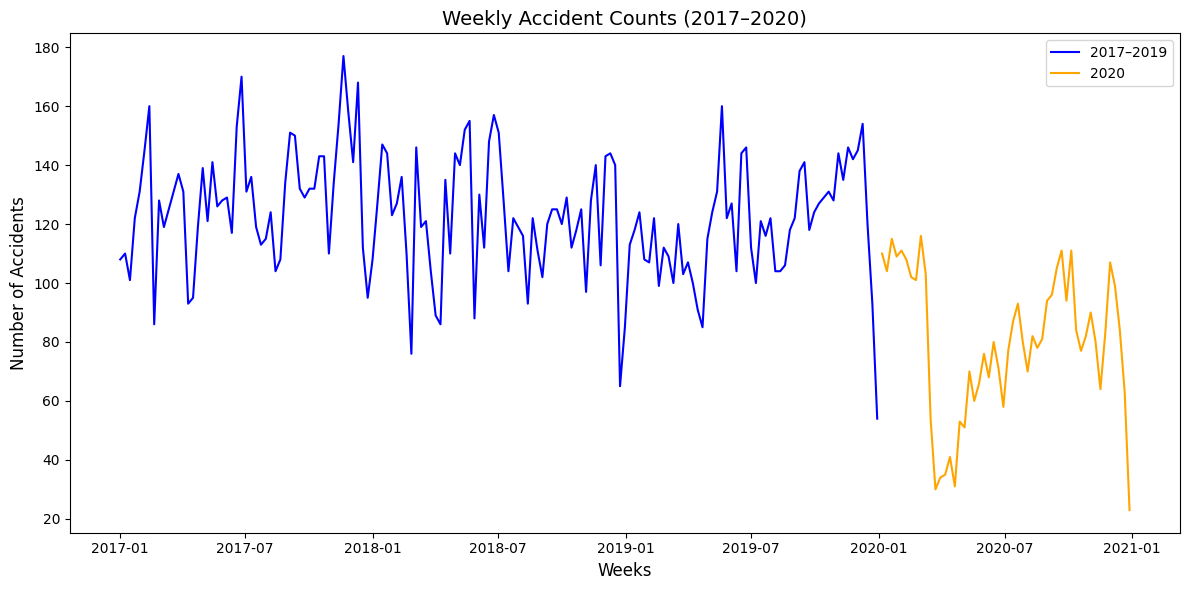

In [22]:
# Separate the data into two timeframes
pre_2020 = weekly_accidents[weekly_accidents.index < '2020-01-01']
year_2020 = weekly_accidents[weekly_accidents.index >= '2020-01-01']

# Plot the data
plt.figure(figsize=(12, 6))

# Line for 2017–2019
plt.plot(pre_2020.index, pre_2020['accident_count'], linestyle='-', color='blue', label='2017–2019')

# Line for 2020
plt.plot(year_2020.index, year_2020['accident_count'], linestyle='-', color='orange', label='2020')

# Add labels, title, and legend
plt.title('Weekly Accident Counts (2017–2020)', fontsize=14)
plt.xlabel('Weeks', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.legend(fontsize=10)

# Display the plot
plt.tight_layout()
plt.savefig('Weekly Accident Counts (2017–2020)', dpi=300, bbox_inches='tight')
plt.show()

## Decomposing

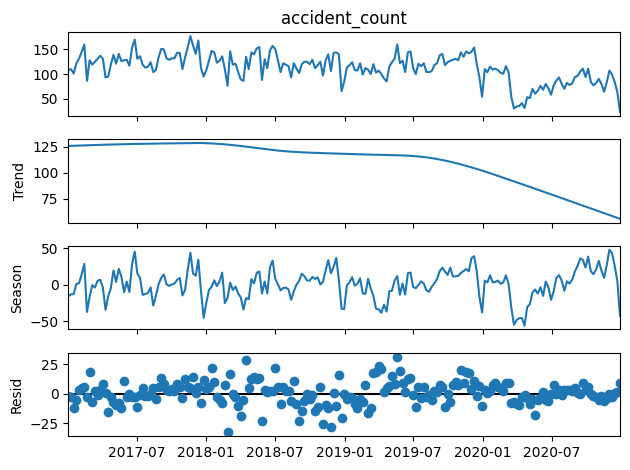

In [23]:
from statsmodels.tsa.seasonal import STL
stl = STL(weekly_accidents['accident_count'])  
result = stl.fit()
result.plot()
plt.show()

## Investigating Stationarity of Time Series

In [24]:
from statsmodels.tsa.stattools import adfuller
ADF_test = adfuller(weekly_accidents['accident_count'])
print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -2.3741491592567234; p-value 0.1491659254946479


NOT STATIONARY !

### First Differencing

In [25]:
# Applying differencing to for stationarity
diff_1 = weekly_accidents[['accident_count']].diff(1).dropna()
diff_1.head()

,accident_count
date,
2017-01-09,2.0
2017-01-16,-9.0
2017-01-23,21.0
2017-01-30,9.0
2017-02-06,14.0


In [26]:
# Testing the differenced series for stationarity
ADF_test = adfuller(diff_1)[:2]
print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -9.041477039732388; p-value 5.119571353131235e-15


Since p value is < 0.05, series is stationary now

## ACF & PACF Plot

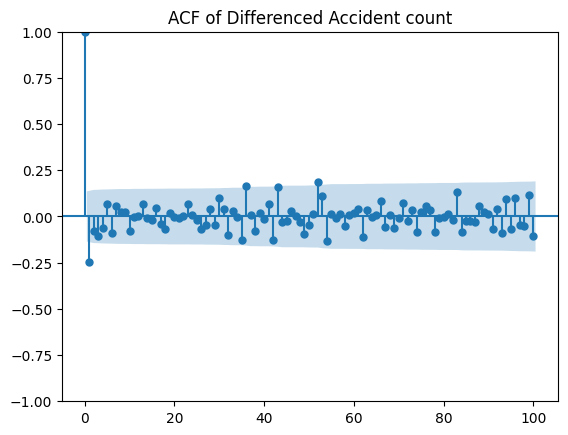

In [27]:
# Plot of ACF to understand the series
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(diff_1, lags=100)
plt.title('ACF of Differenced Accident count')
plt.show()

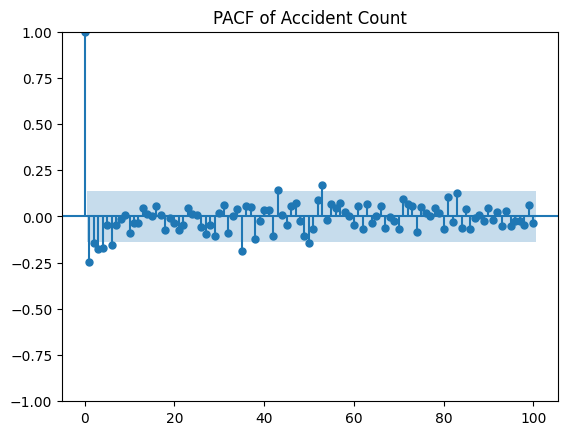

In [28]:
plot_pacf(diff_1, lags=100)
plt.title('PACF of Accident Count')
plt.show()

## USING ARIMA, first determining order

### Train & Test

In [29]:
# Split the data into train and test sets
train_data = weekly_accidents[weekly_accidents.index.year < 2020]  # Data from 2017 to 2019
test_data = weekly_accidents[weekly_accidents.index.year == 2020]  # Data from 2020

In [30]:
train_data.head()

,accident_count
date,
2017-01-02,108
2017-01-09,110
2017-01-16,101
2017-01-23,122
2017-01-30,131


### Function to Calculate AIC of corresponding order

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
from statsmodels.tsa.arima.model import ARIMA

def calculate_arma_aic(train_data, p_range, q_range):
    """
    Function to calculate AIC for multiple ARIMA(p, 1, q) combinations.
    Stores the combinations of p, q, and their corresponding AIC values.
    """
    aic_results = []
    
    # Generate all combinations of p and q using product
    for p, q in product(p_range, q_range):
        try:
            # Fit the ARIMA model 
            model = ARIMA(train_data, order=(p, 1, q))
            model_fitted = model.fit()
            
            # Append results to the list
            aic_results.append((p, q, model_fitted.aic))
        except:
            # Skip if the model fitting fails (e.g., due to non-convergence)
            continue
    
    # Create a DataFrame to store results
    aic_df = pd.DataFrame(aic_results, columns=['p', 'q', 'AIC'])
    
    # Sort by AIC value in ascending order
    aic_df_sorted = aic_df.sort_values(by='AIC').reset_index(drop=True)
    
    return aic_df_sorted

In [96]:
from itertools import product
# Define the range for p and q
p_range = np.arange(0, 15, 1)  # For example, try p from 0 to 14
q_range = np.arange(0, 15, 1)  # Similarly, try q from 0 to 14

# Apply the function on the training data (you can use train_data from earlier)
aic_results = calculate_arma_aic(train_data['accident_count'], p_range, q_range)

In [34]:
aic_results.head()

,p,q,AIC
0,1,1,1368.584579
1,0,3,1369.706290
2,2,1,1370.490222
3,1,2,1370.518886
4,2,2,1370.759792


### Train ARIMA using train set

In [35]:
model_arima = ARIMA(train_data['accident_count'], order=(1, 1, 1))
model_arima_fitted = model_arima.fit()

### Evaluate using Q-Q plot & Ljung-Box test

,lb_stat,lb_pvalue
1,0.009530,0.922233
2,0.014221,0.992915
3,0.116296,0.989813
4,0.304992,0.989490
5,1.222124,0.942737
6,1.222128,0.975778
7,1.314143,0.988057
8,2.086196,0.978255
9,2.160868,0.988661
10,2.536755,0.990329


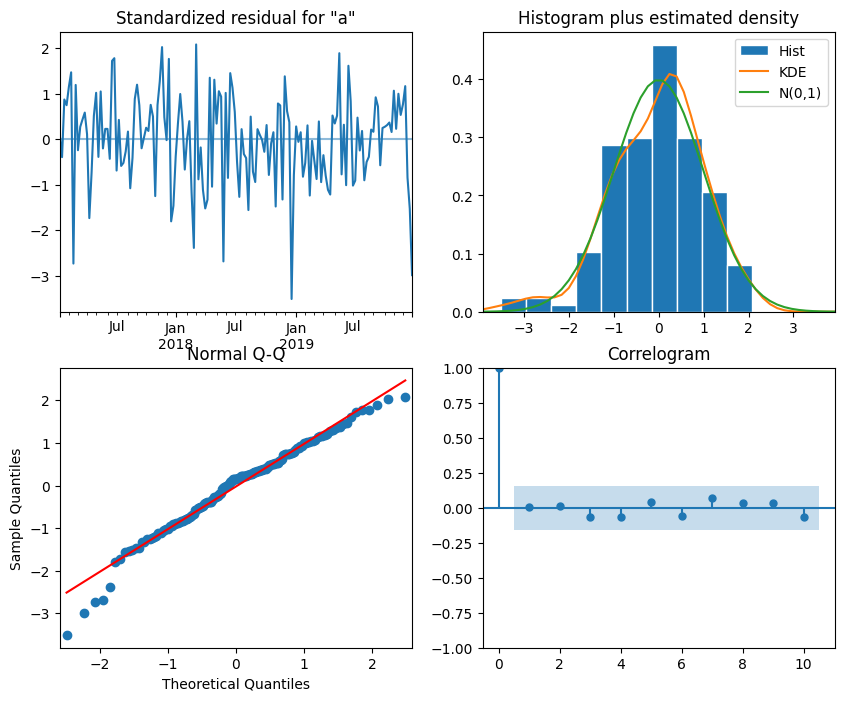

In [36]:
# Plots the Q-Q plot
model_arima_fitted.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(model_arima_fitted.resid)

p value is > 0.05, means points have no autocorrelation

### Forecasting using both ARIMA (1,1,1)


In [92]:
# Forecasting the test set using both naive_model (using the last values) and arima
len_test = len(test_data)
arima_pred = model_arima_fitted.get_forecast(len_test).predicted_mean.values

test_data['forecasted_accident_count'] = np.round(arima_pred)


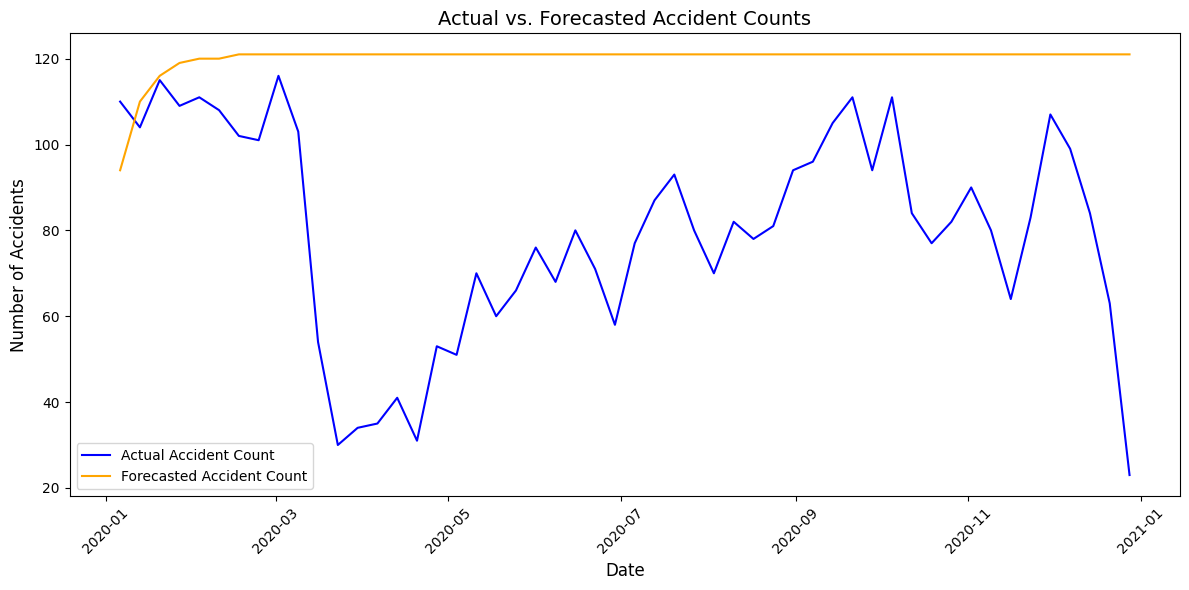

In [93]:
# Plot actual and forecasted accident counts
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['accident_count'], label='Actual Accident Count', linestyle='-', color='blue')
plt.plot(test_data.index, test_data['forecasted_accident_count'], label='Forecasted Accident Count', linestyle='-', color='orange')

# Add title and labels
plt.title('Actual vs. Forecasted Accident Counts', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)

# Rotate x-axis ticks for better visibility
plt.xticks(rotation=45)

# Add legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.savefig('Actual vs Forecasted Weekly Accident Counts', dpi=300, bbox_inches='tight')
plt.show()

1) Although the testing has shown that ARIMA (1,1,1) model capture most of the variance in data but forecast didnt go well.
2) The forecasted accident count stabilizes at 121 after a few weeks
3) This suggests that the model fails to adapt to the variations in the actual accident counts, especially during periods of significant drops (e.g., March-April 2020).

In [94]:
from sklearn.metrics import mean_squared_error
arima_rmse = mean_squared_error(test_data['accident_count'],test_data['forecasted_accident_count'],squared=False)
arima_rmse

47.77008236575241

In [95]:
rmse_percentage = (arima_rmse / test_data['accident_count'].mean()) * 100
print(f"RMSE as percentage of mean: {rmse_percentage}%")

RMSE as percentage of mean: 59.827656142079135%


The actual accident counts typically range from 23 to 111. RMSE of 47.48 is almost 59% of the typical range of accident counts, which is relatively large and indicates poor predictive performance

# 7. Identify the three Local Super Output Areas (LSOAs) of Hull city that recorded the highest number of road accidents in the first three months of 2020, then employ a time series model to forecast daily accident occurrences for the upcoming month (e.g., July), leveraging data from the preceding six months (e.g., January to June) for these high-incident areas.

## Identifying three LSOAs of Hull City with Highest Road Accidents in first three months of 2020

In [41]:
query = """
    SELECT lsoa_of_accident_location, COUNT(*) AS accident_count
    FROM accident
    WHERE lsoa_of_accident_location BETWEEN 'E01012756' AND 'E01012918'
    AND substr(date, 7, 4) || '-' || substr(date, 4, 2) || '-' || substr(date, 1, 2) 
        BETWEEN '2020-01-01' AND '2020-03-31'
    GROUP BY lsoa_of_accident_location
    ORDER BY accident_count DESC
    LIMIT 3;
"""

# Execute the query
cur.execute(query)

# Fetch and display the results
top_lsoas = cur.fetchall()
for row in top_lsoas:
    print(row)

('E01012817', 10)
('E01012889', 7)
('E01012848', 7)


## Time series model to forecast daily accident count

### Filtering out the required data

In [42]:
# SQL query to get daily accident counts for specified LSOAs (E01012817, E01012848, E01012889)
query = """
SELECT 
    date,
    lsoa_of_accident_location,
    COUNT(*) AS accident_count
FROM accident
WHERE lsoa_of_accident_location IN ('E01012817', 'E01012848', 'E01012889')
  AND substr(date, 7, 4) || '-' || 
      substr(date, 4, 2) || '-' || 
      substr(date, 1, 2) BETWEEN '2020-01-01' AND '2020-03-31'
GROUP BY date, lsoa_of_accident_location
ORDER BY date;
"""

# Execute the query
cur.execute(query)

# Fetch the results
results = cur.fetchall()

In [43]:
results

[('02/01/2020', 'E01012817', 2),
 ('03/01/2020', 'E01012817', 1),
 ('03/02/2020', 'E01012817', 1),
 ('10/01/2020', 'E01012848', 1),
 ('10/01/2020', 'E01012889', 1),
 ('11/02/2020', 'E01012817', 1),
 ('11/02/2020', 'E01012889', 1),
 ('11/03/2020', 'E01012817', 1),
 ('13/01/2020', 'E01012817', 1),
 ('13/03/2020', 'E01012889', 1),
 ('16/02/2020', 'E01012889', 1),
 ('17/01/2020', 'E01012817', 1),
 ('17/03/2020', 'E01012889', 1),
 ('18/02/2020', 'E01012848', 1),
 ('22/01/2020', 'E01012817', 1),
 ('22/01/2020', 'E01012848', 1),
 ('23/01/2020', 'E01012817', 1),
 ('24/02/2020', 'E01012889', 1),
 ('25/02/2020', 'E01012848', 1),
 ('26/02/2020', 'E01012848', 1),
 ('26/03/2020', 'E01012889', 1),
 ('27/02/2020', 'E01012848', 1),
 ('30/03/2020', 'E01012848', 1)]

In [44]:
df = pd.DataFrame(results, columns=['date', 'lsoa_of_accident_location', 'accident_count'])

# Now proceed with the steps in pandas to pivot and prepare the data
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
daily_accidents_pivot = df.pivot(index='date', columns='lsoa_of_accident_location', values='accident_count')

# Generate the full date range from 01-01-2020 to 31-07-2020
full_date_range = pd.date_range(start='2020-01-01', end='2020-07-31')

# Reindex the pivot table to include all dates in the full date range
daily_accidents_pivot = daily_accidents_pivot.reindex(full_date_range, fill_value=0)

# Replace NaN values with 0 (for any missing data)
daily_accidents_pivot.fillna(0, inplace=True)

# Display the final pivot table
daily_accidents_pivot.head()

lsoa_of_accident_location,E01012817,E01012848,E01012889
2020-01-01,0.0,0.0,0.0
2020-01-02,2.0,0.0,0.0
2020-01-03,1.0,0.0,0.0
2020-01-04,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0


## Visualising the data

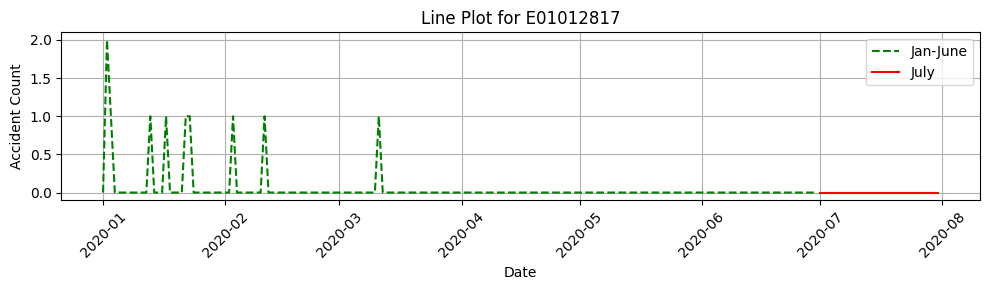

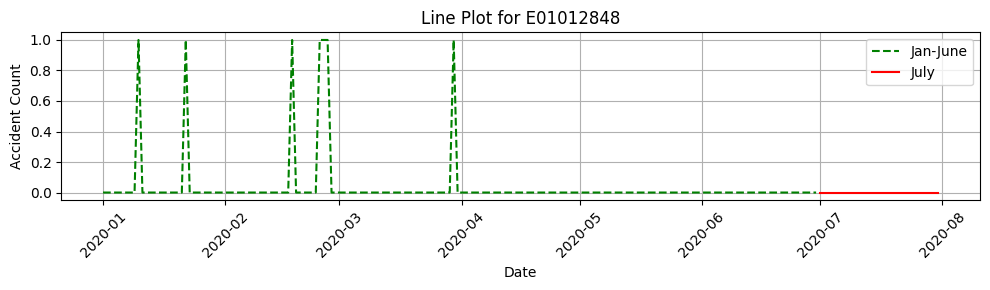

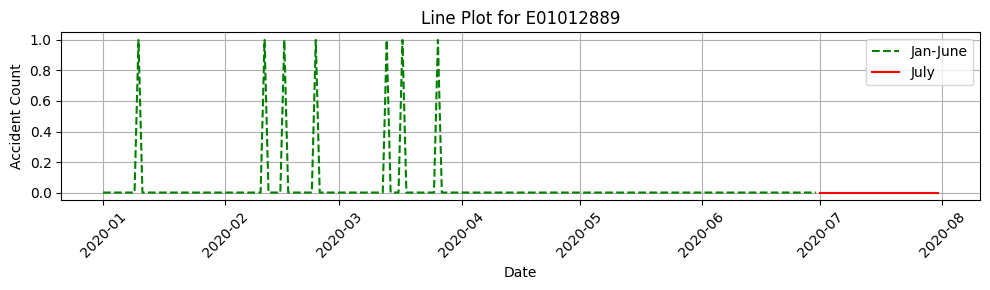

In [45]:
# List of columns to plot
columns_to_plot = ['E01012817', 'E01012848', 'E01012889']

# Loop through each column and create a plot
for column in columns_to_plot:
    plt.figure(figsize=(10, 3))  # Set figure size
    
    # Split data into January-June and July
    jan_to_june_data = daily_accidents_pivot[column][daily_accidents_pivot.index.month <= 6]
    july_data = daily_accidents_pivot[column][daily_accidents_pivot.index.month == 7]
    
    # Plot January to June with one color
    plt.plot(jan_to_june_data.index, jan_to_june_data, linestyle='--', color='g', label='Jan-June')
    
    # Plot July with another color
    plt.plot(july_data.index, july_data, linestyle='-', color='r', label='July')

    plt.title(f"Line Plot for {column}")  # Title of the plot
    plt.xlabel("Date")  # X-axis label
    plt.ylabel("Accident Count")  # Y-axis label
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(True)  # Add grid
    plt.legend()  # Add a legend
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.savefig(f"Line Plot for {column}", dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot

### Decomposing

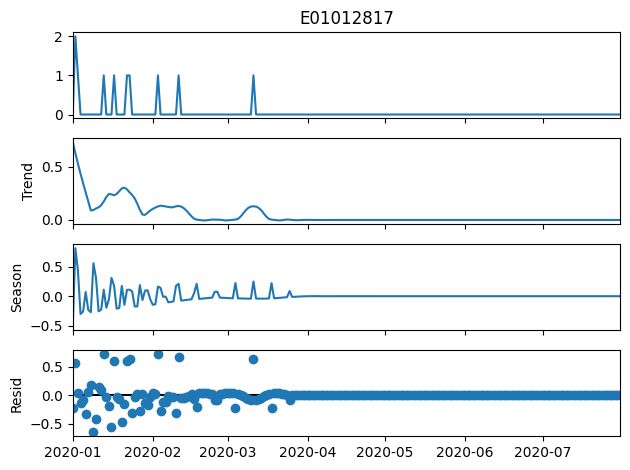

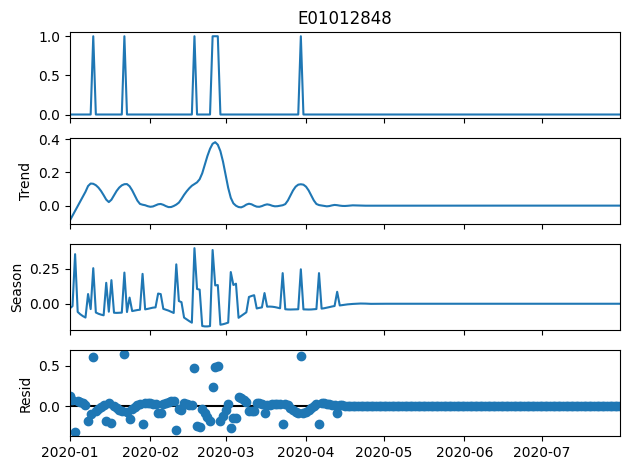

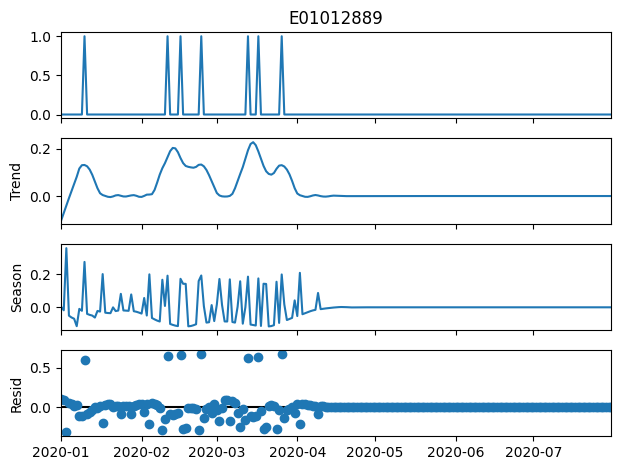

In [46]:
from statsmodels.tsa.seasonal import STL
columns_to_decompose = ['E01012817', 'E01012848', 'E01012889'] 

#Loop through the columns and perform STL decomposition for each
for column in columns_to_decompose:
    stl = STL(daily_accidents_pivot[column])  
    result = stl.fit()
    result.plot()
    plt.show()

### Stationary Test

In [47]:
def perform_adf_test_for_columns(df, columns):
    """
    This function performs the Augmented Dickey-Fuller (ADF) test for each column in the dataframe.
    """
    for column in columns:
        ADF_test = adfuller(df[column])[:2]
        print(f"ADF Test for {column}:")
        print(f"ADF Statistic: {ADF_test[0]}; p-value: {ADF_test[1]}")
        print("-" * 50)  

In [48]:
from statsmodels.tsa.stattools import adfuller
columns_to_test = ['E01012817', 'E01012848', 'E01012889']
perform_adf_test_for_columns(daily_accidents_pivot, columns_to_test)

ADF Test for E01012817:
ADF Statistic: -2.272089488509002; p-value: 0.1811277067571842
--------------------------------------------------
ADF Test for E01012848:
ADF Statistic: -11.089789241205827; p-value: 4.1095590399476853e-20
--------------------------------------------------
ADF Test for E01012889:
ADF Statistic: -2.706353249984263; p-value: 0.07294531698948575
--------------------------------------------------


E01012817 & E01012889 are not stationary

### First Differencing

In [49]:
# Applying differencing to for stationarity
diff_1_E01012817 = daily_accidents_pivot[['E01012817']].diff(1).dropna()
diff_1_E01012889 = daily_accidents_pivot[['E01012889']].diff(1).dropna()

In [50]:
# Checking Stationary
ADF_test_E01012817 = adfuller(diff_1_E01012817)[:2]
print(f"ADF Statistic: {ADF_test_E01012817[0]}; p-value {ADF_test_E01012817[1]}")
ADF_test_E01012889 = adfuller(diff_1_E01012889)[:2]
print(f"ADF Statistic: {ADF_test_E01012889[0]}; p-value {ADF_test_E01012889[1]}")

ADF Statistic: -9.324197883392634; p-value 9.70941113143915e-16
ADF Statistic: -7.951498563599183; p-value 3.117124449978512e-12


Series are now stationary

### ACF & PACF Plots

In [51]:
daily_accidents_pivot.head()

lsoa_of_accident_location,E01012817,E01012848,E01012889
2020-01-01,0.0,0.0,0.0
2020-01-02,2.0,0.0,0.0
2020-01-03,1.0,0.0,0.0
2020-01-04,0.0,0.0,0.0
2020-01-05,0.0,0.0,0.0


### ACF & PACF Plots for E01012817

In [52]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

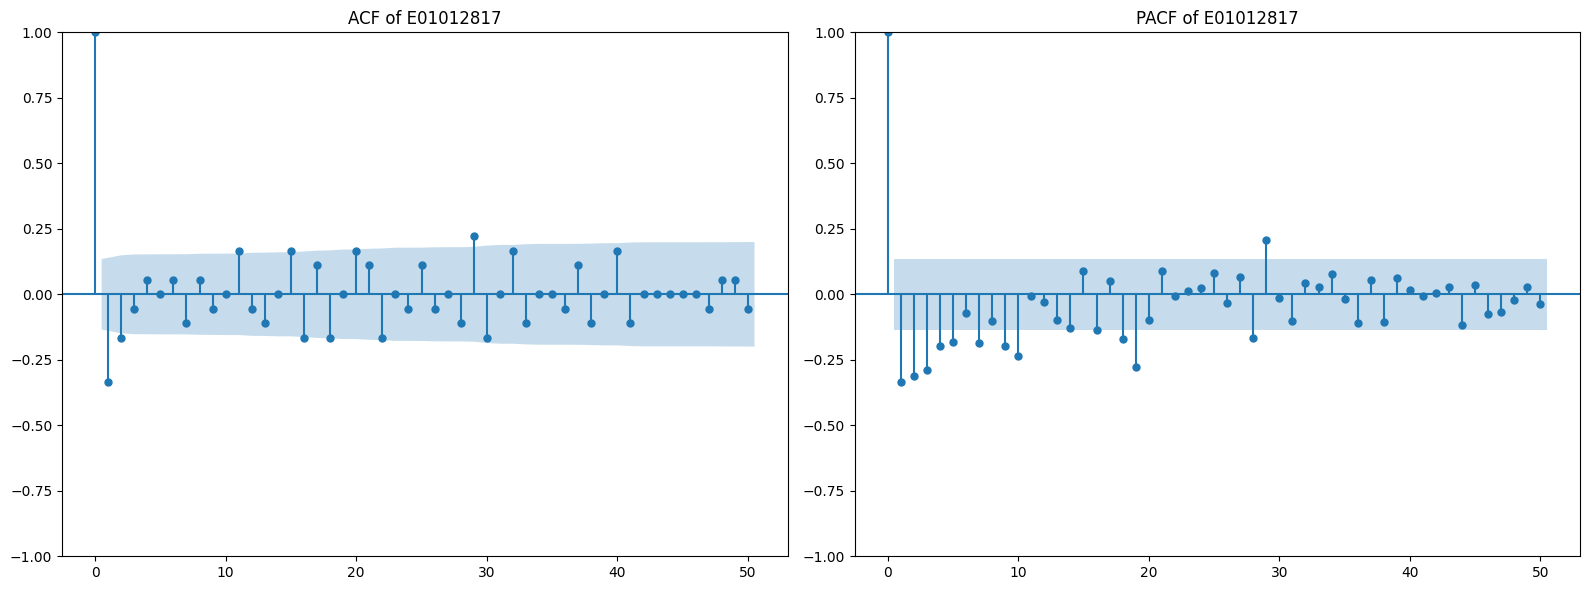

In [53]:
# Combined ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# ACF Plot
plot_acf(diff_1_E01012817, lags=50, ax=axes[0])
axes[0].set_title('ACF of E01012817')

# PACF Plot
plot_pacf(diff_1_E01012817, lags=50, ax=axes[1])
axes[1].set_title('PACF of E01012817')

plt.tight_layout()
plt.show()

### ACF & PACF Plots E01012848

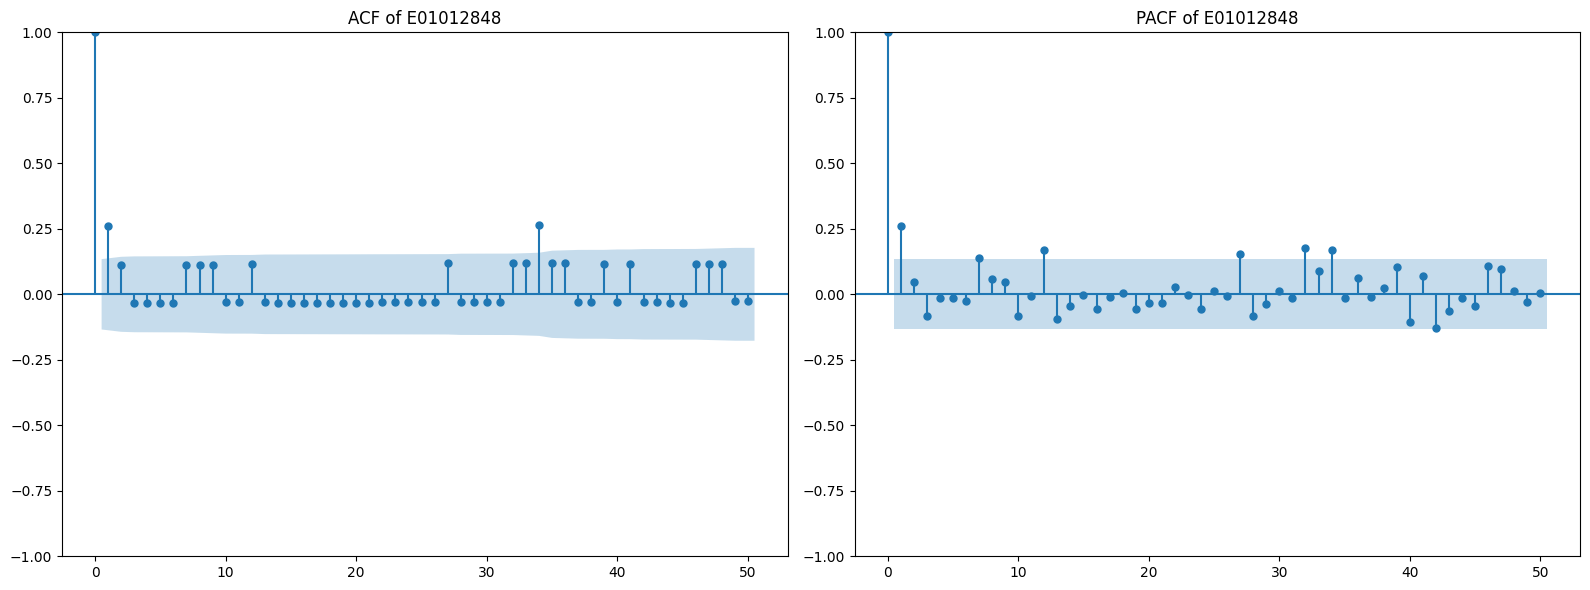

In [54]:
# Combined ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# ACF Plot
plot_acf(daily_accidents_pivot["E01012848"], lags=50, ax=axes[0])
axes[0].set_title('ACF of E01012848')

# PACF Plot
plot_pacf(daily_accidents_pivot["E01012848"], lags=50, ax=axes[1])
axes[1].set_title('PACF of E01012848')

plt.tight_layout()
plt.show()

### ACF & PACF Plots E01012889

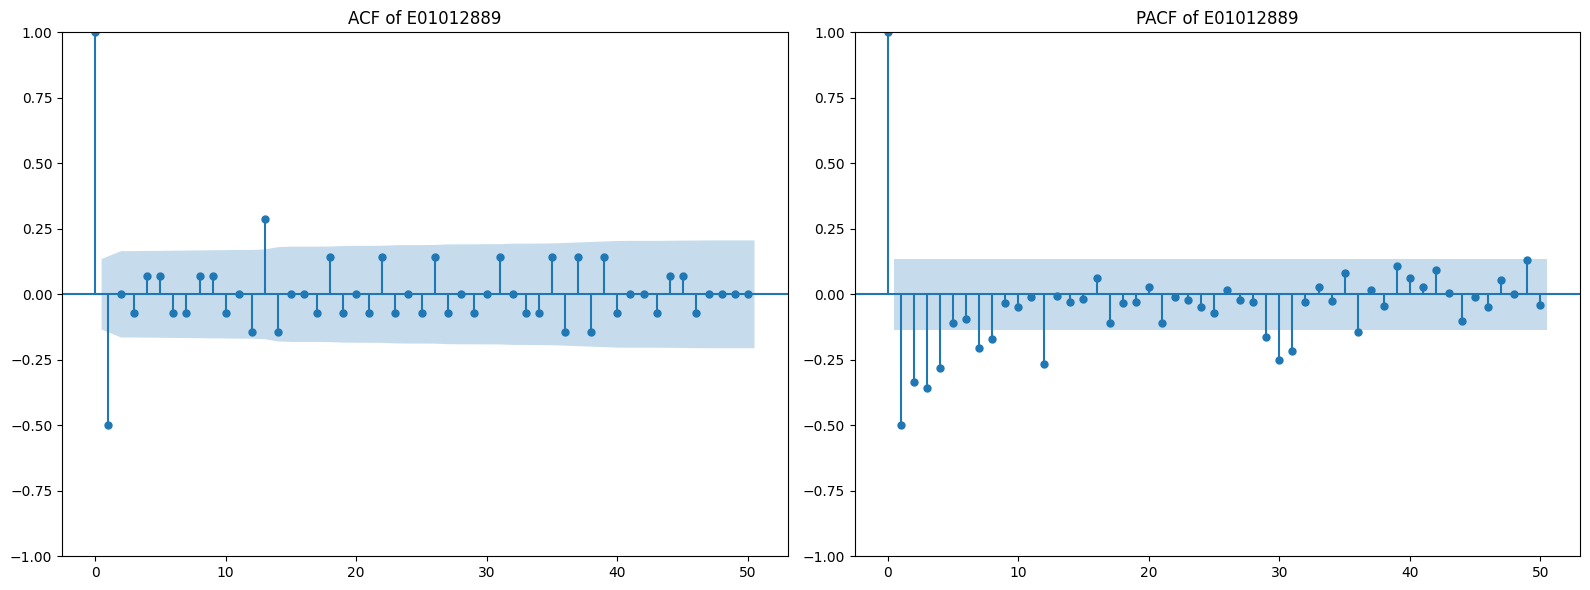

In [55]:
# Combined ACF and PACF plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 row, 2 columns

# ACF Plot
plot_acf(diff_1_E01012889, lags=50, ax=axes[0])
axes[0].set_title('ACF of E01012889')

# PACF Plot
plot_pacf(diff_1_E01012889, lags=50, ax=axes[1])
axes[1].set_title('PACF of E01012889')

plt.tight_layout()
plt.show()

### Train/Test Split

In [56]:
train_data_lsoa = daily_accidents_pivot[daily_accidents_pivot.index.month <= 6]
test_data_lsoa = daily_accidents_pivot[daily_accidents_pivot.index.month >= 7]

## Using ARMA for E01012848 & ARIMA for E01012817 & E01012889

### ARMA for E01012848

In [58]:
def calculate_best_arma_aic(train_data, p_range, q_range):
    """
    Function to calculate AIC for multiple ARMA(p, q) combinations.
    Stores the combinations of p, q, and their corresponding AIC values.
    Returns the combinations sorted by the lowest AIC.
    """
    aic_results = []
    
    # Generate all combinations of p and q using product
    for p, q in product(p_range, q_range):
        try:
            # Fit the ARMA model (ARIMA with d=0 means it's ARMA)
            model = ARIMA(train_data, order=(p, 0, q))  # d=0 for ARMA
            model_fitted = model.fit()
            
            # Append results to the list
            aic_results.append((p, q, model_fitted.aic))
        except:
            # Skip if the model fitting fails (e.g., due to non-convergence)
            continue
    
    # Create a DataFrame to store results
    best_aic_df = pd.DataFrame(aic_results, columns=['p', 'q', 'AIC'])
    
    # Sort by AIC value in ascending order
    best_aic_df_sorted = best_aic_df.sort_values(by='AIC').reset_index(drop=True)
    
    return best_aic_df_sorted

In [59]:
from itertools import product
# Define the range of p and q for ARMA model orders
p_range = range(0, 16)  # Test AR orders from 0 to 15
q_range = range(0, 16)  # Test MA orders from 0 to 15

# Call the function to get the best ARMA model based on AIC
aic_results_E01012848 = calculate_best_arma_aic(train_data_lsoa['E01012848'], p_range, q_range)

In [60]:
aic_results_E01012848.head()

,p,q,AIC
0,5,6,-90.240606
1,1,0,-89.984460
2,0,2,-89.323092
3,2,5,-88.771929
4,2,0,-88.352799


### ARIMA for E01012817 & E01012889

In [61]:
def calculate_best_arima_aic(train_data, p_range, q_range):
    """
    Function to calculate AIC for multiple ARIMA(p, I, q) combinations.
    Stores the combinations of p, q, and their corresponding AIC values.
    Returns the combinations sorted by the lowest AIC.
    """
    aic_results = []
    
    # Generate all combinations of p and q using product
    for p, q in product(p_range, q_range):
        try:
            # Fit the ARIMA model 
            model = ARIMA(train_data, order=(p, 1, q))  
            model_fitted = model.fit()
            
            # Append results to the list
            aic_results.append((p, q, model_fitted.aic))
        except:
            # Skip if the model fitting fails (e.g., due to non-convergence)
            continue
    
    # Create a DataFrame to store results
    best_aic_df = pd.DataFrame(aic_results, columns=['p', 'q', 'AIC'])
    
    # Sort by AIC value in ascending order
    best_aic_df_sorted = best_aic_df.sort_values(by='AIC').reset_index(drop=True)
    
    return best_aic_df_sorted

### Best order for E01012817

In [62]:
from itertools import product
# Define the range of p and q for ARMA model orders
p_range = range(0, 16)  # Test AR orders from 0 to 15
q_range = range(0, 16)  # Test MA orders from 0 to 15

# Call the function to get the best ARMA model based on AIC
aic_results_E01012817 = calculate_best_arima_aic(train_data_lsoa['E01012817'], p_range, q_range)

In [63]:
aic_results_E01012817.head()

,p,q,AIC
0,15,14,-36.093623
1,15,11,-26.816027
2,14,12,-25.302060
3,15,12,-25.017313
4,10,10,-24.590519


### Best order for E01012889

In [64]:
from itertools import product
# Define the range of p and q for ARMA model orders
p_range = range(0, 16)  # Test AR orders from 0 to 15
q_range = range(0, 16)  # Test MA orders from 0 to 15

# Call the function to get the best ARMA model based on AIC
aic_results_E01012889 = calculate_best_arima_aic(train_data_lsoa['E01012889'], p_range, q_range)

In [65]:
aic_results_E01012889.head()

,p,q,AIC
0,2,3,-77.958501
1,4,6,-76.555162
2,2,4,-76.466293
3,3,3,-75.819203
4,2,5,-74.685722


### Building & Evaluating Model using Q-Q plot and Ljung-Box test.

### Evaluating E01012848

In [66]:
def train_arma_model(train_data, p, q):
    """
    Function to train an ARMA(p, q) model and return the fitted model.
    """
    model = ARIMA(train_data, order=(p, 0, q))  # ARMA model with d=0 (no differencing)
    fitted_model = model.fit()  # Fit the model
    return fitted_model

In [67]:
E01012848_arma_model = train_arma_model(train_data_lsoa['E01012848'], 5, 6)

,lb_stat,lb_pvalue
1,0.010211,0.919512
2,0.016848,0.991611
3,0.772924,0.855932
4,0.814281,0.936523
5,0.902173,0.970064
6,1.060868,0.983199
7,1.205562,0.990798
8,2.536402,0.960012
9,4.220600,0.896302
10,4.589175,0.916881


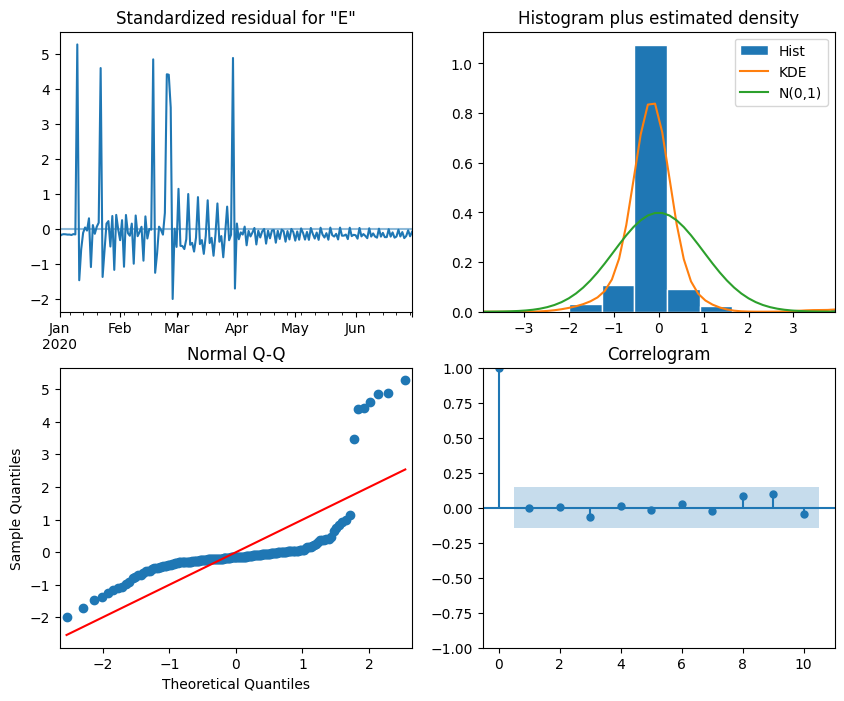

In [68]:
from statsmodels.stats.diagnostic import acorr_ljungbox
# Plots the Q-Q plot
E01012848_arma_model.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
acorr_ljungbox(E01012848_arma_model.resid)

### Evaluating E01012817

In [69]:
def train_arima_model(train_data, p, q):
    """
    Function to train an ARIMA(p, 1, q) model and return the fitted model.
    """
    model = ARIMA(train_data, order=(p, 1, q))  
    fitted_model = model.fit()  # Fit the model
    return fitted_model

In [70]:
E01012817_arima_model = train_arima_model(train_data_lsoa['E01012817'], 15, 14)

,lb_stat,lb_pvalue
1,0.198309,0.656089
2,0.218589,0.896466
3,2.655304,0.447876
4,2.755677,0.599508
5,3.464013,0.628840
6,3.704568,0.716583
7,5.270196,0.627027
8,5.384851,0.715761
9,7.036284,0.633342
10,8.814930,0.549753


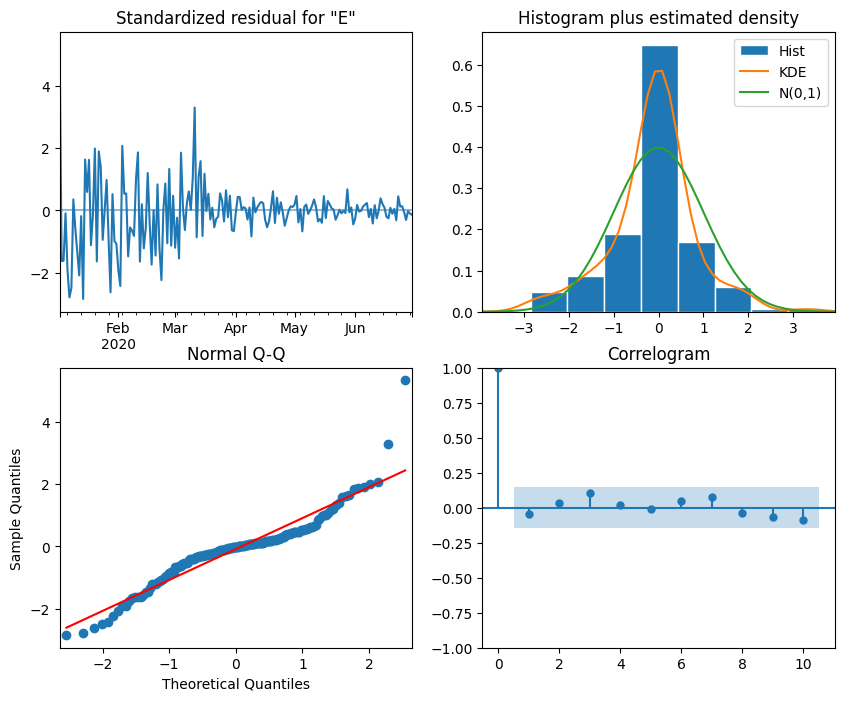

In [71]:
# Plots the Q-Q plot
E01012817_arima_model.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
acorr_ljungbox(E01012817_arima_model.resid)

### Evaluating E01012889

In [72]:
E01012889_arima_model = train_arima_model(train_data_lsoa['E01012889'], 2, 3)

,lb_stat,lb_pvalue
1,0.126420,0.722173
2,0.273006,0.872404
3,1.067492,0.784927
4,1.067875,0.899335
5,1.955139,0.855317
6,2.122695,0.908075
7,2.128951,0.952360
8,2.391676,0.966591
9,2.451029,0.982172
10,2.570747,0.989804


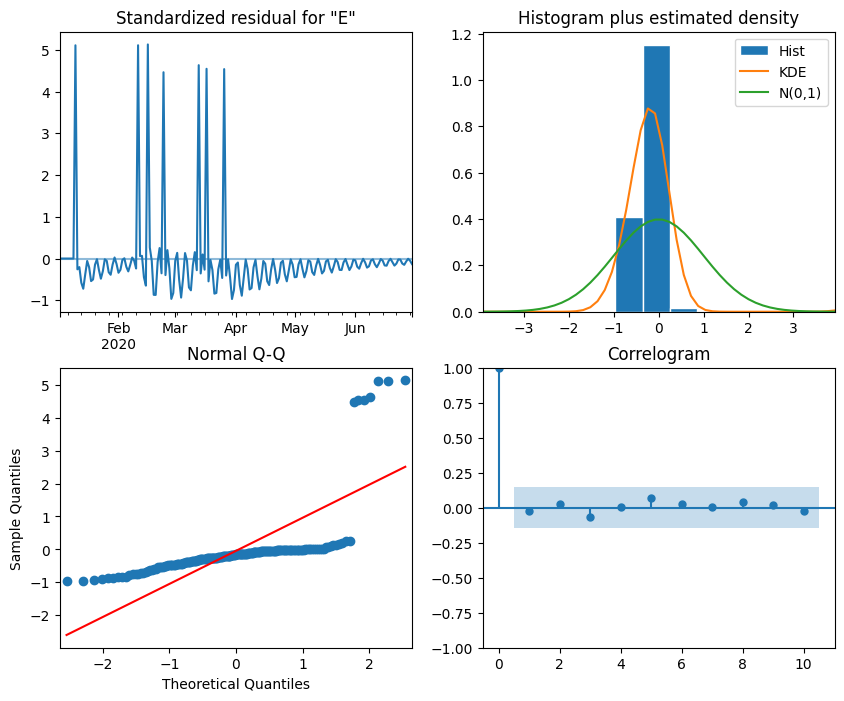

In [73]:
# Plots the Q-Q plot
E01012889_arima_model.plot_diagnostics(figsize=(10,8));

# Evaluation using Ljung-Box test
acorr_ljungbox(E01012889_arima_model.resid)

## Forecasting

In [74]:
def forecast_and_plot_arma(test_data, model, column_name, forecast_column_name, forecast_length):
    """
    Forecast future values using an ARMA model and plot actual vs forecasted values.
    """
    #Forecasting the test set
    forecasted_values = model.get_forecast(forecast_length).predicted_mean.values
    test_data[forecast_column_name] = np.round(forecasted_values)  #Round forecasted values

    #Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[column_name], label='Actual Accident Count', marker='o')
    plt.plot(test_data.index, test_data[forecast_column_name], label='Forecasted Accident Count', marker='x', linestyle='--', color='orange')
    #Add title and labels
    plt.title(f'Actual vs. Forecasted Accident Counts for {column_name}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    # Add legend
    plt.legend()
    # Display the plot
    plt.tight_layout()
    safe_filename = f"Actual_vs_Forecasted_Accident_Counts_{column_name}.png"  # Replace spaces with underscores and add extension
    plt.savefig(safe_filename, dpi=300, bbox_inches='tight')
    plt.show()

    return test_data

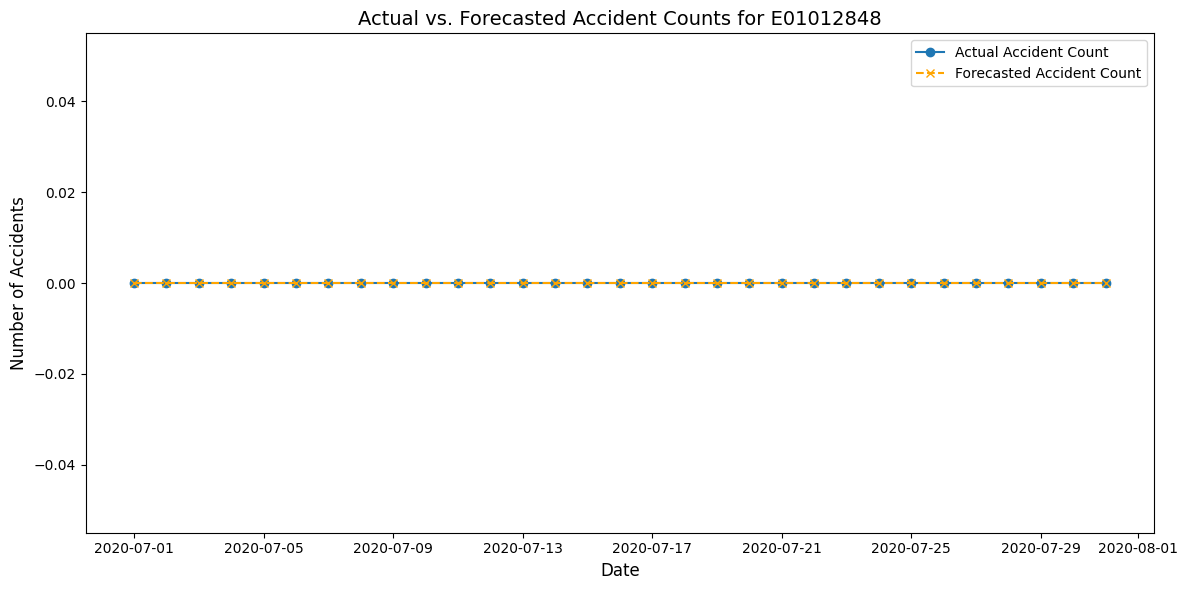

In [75]:
forecast_length = len(test_data_lsoa)  

test_data_lsoa = forecast_and_plot_arma(
    test_data_lsoa, E01012848_arma_model, 'E01012848', 'forecasted_accident_count_E01012848', forecast_length
)

In [76]:
def forecast_and_plot_arima(test_data, model, column_name, forecast_column_name, forecast_length):
    """
    Forecast future values using an ARIMA model and plot actual vs forecasted values.
    """
    #Forecasting the test set
    forecasted_values = model.get_forecast(forecast_length).predicted_mean.values
    test_data[forecast_column_name] = np.round(forecasted_values)  #Round forecasted values

    #Plot actual vs forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data[column_name], label='Actual Accident Count', marker='o')
    plt.plot(test_data.index, test_data[forecast_column_name], label='Forecasted Accident Count', marker='x', linestyle='--', color='orange')
    #Add title and labels
    plt.title(f'Actual vs. Forecasted Accident Counts for {column_name}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Accidents', fontsize=12)
    # Add legend
    plt.legend()
    # Display the plot
    plt.tight_layout()
    safe_filename = f"Actual_vs_Forecasted_Accident_Counts_{column_name}.png"  # Replace spaces with underscores and add extension
    plt.savefig(safe_filename, dpi=300, bbox_inches='tight')
    plt.show()

    return test_data

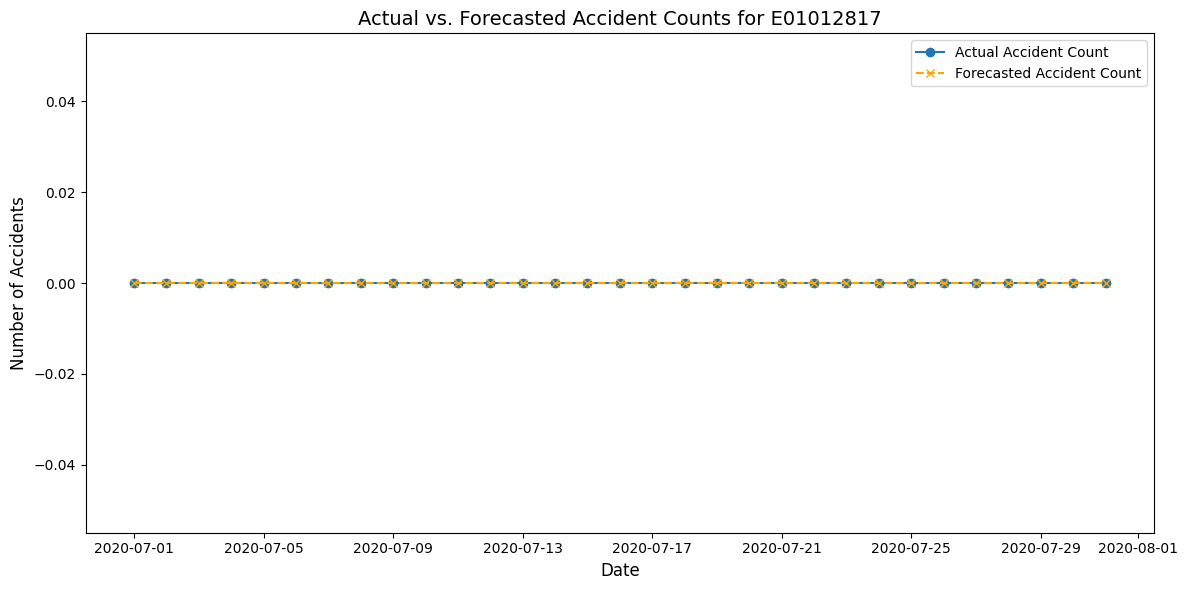

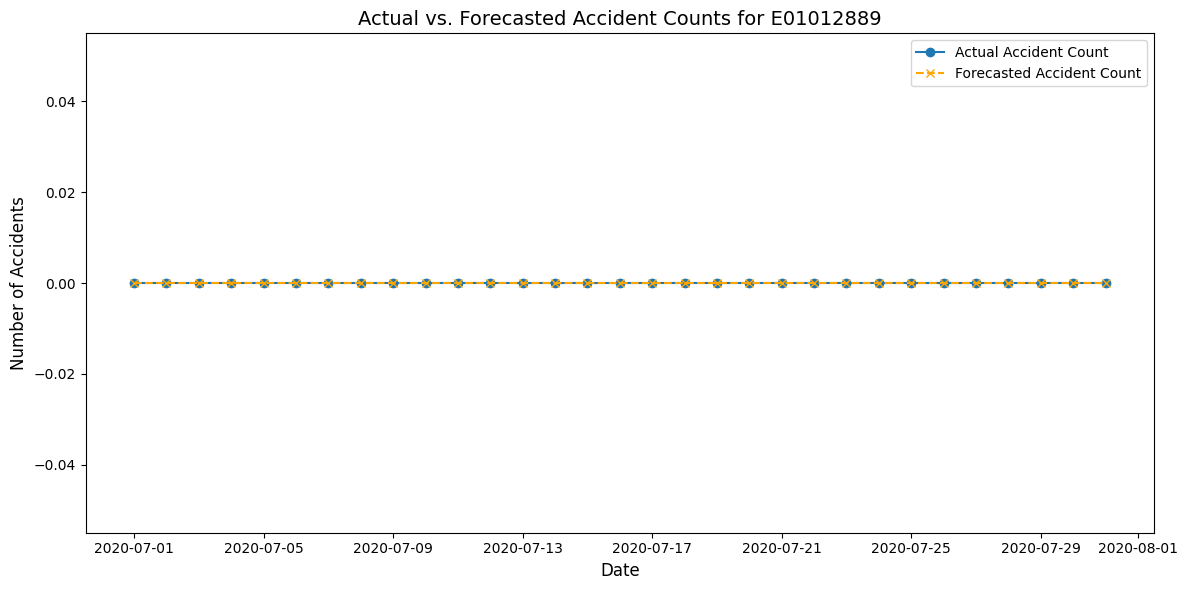

In [77]:
forecast_length = len(test_data_lsoa)  

test_data_lsoa = forecast_and_plot_arima(
    test_data_lsoa, E01012817_arima_model, 'E01012817', 'forecasted_accident_count_E01012817', forecast_length
)

test_data_lsoa = forecast_and_plot_arima(
    test_data_lsoa, E01012889_arima_model, 'E01012889', 'forecasted_accident_count_E01012889', forecast_length
)

In [78]:
from sklearn.metrics import mean_squared_error
def calculate_rmse(true_values, forecasted_values):
    """
    Function to calculate RMSE (Root Mean Squared Error)
    """
    return mean_squared_error(true_values, forecasted_values, squared=False)

arma_rmse_E01012817 = calculate_rmse(test_data_lsoa['E01012817'], test_data_lsoa['forecasted_accident_count_E01012817'])
arma_rmse_E01012848 = calculate_rmse(test_data_lsoa['E01012848'], test_data_lsoa['forecasted_accident_count_E01012848'])
arma_rmse_E01012889 = calculate_rmse(test_data_lsoa['E01012889'], test_data_lsoa['forecasted_accident_count_E01012889'])

print(f"RMSE for E01012817: {arma_rmse_E01012817}")
print(f"RMSE for E01012848: {arma_rmse_E01012848}")
print(f"RMSE for E01012889: {arma_rmse_E01012889}")


RMSE for E01012817: 0.0
RMSE for E01012848: 0.0
RMSE for E01012889: 0.0


# 8) Construct a social network using the provided data and visualise the network, then provide the basic network characteristics, including numbers of nodes and edges, network density, average degree.

In [79]:
import networkx as nx
edges = []
with open('facebook_combined.txt', 'r') as file:
    for line in file:
        node1, node2 = map(int, line.strip().split())
        edges.append((node1, node2))

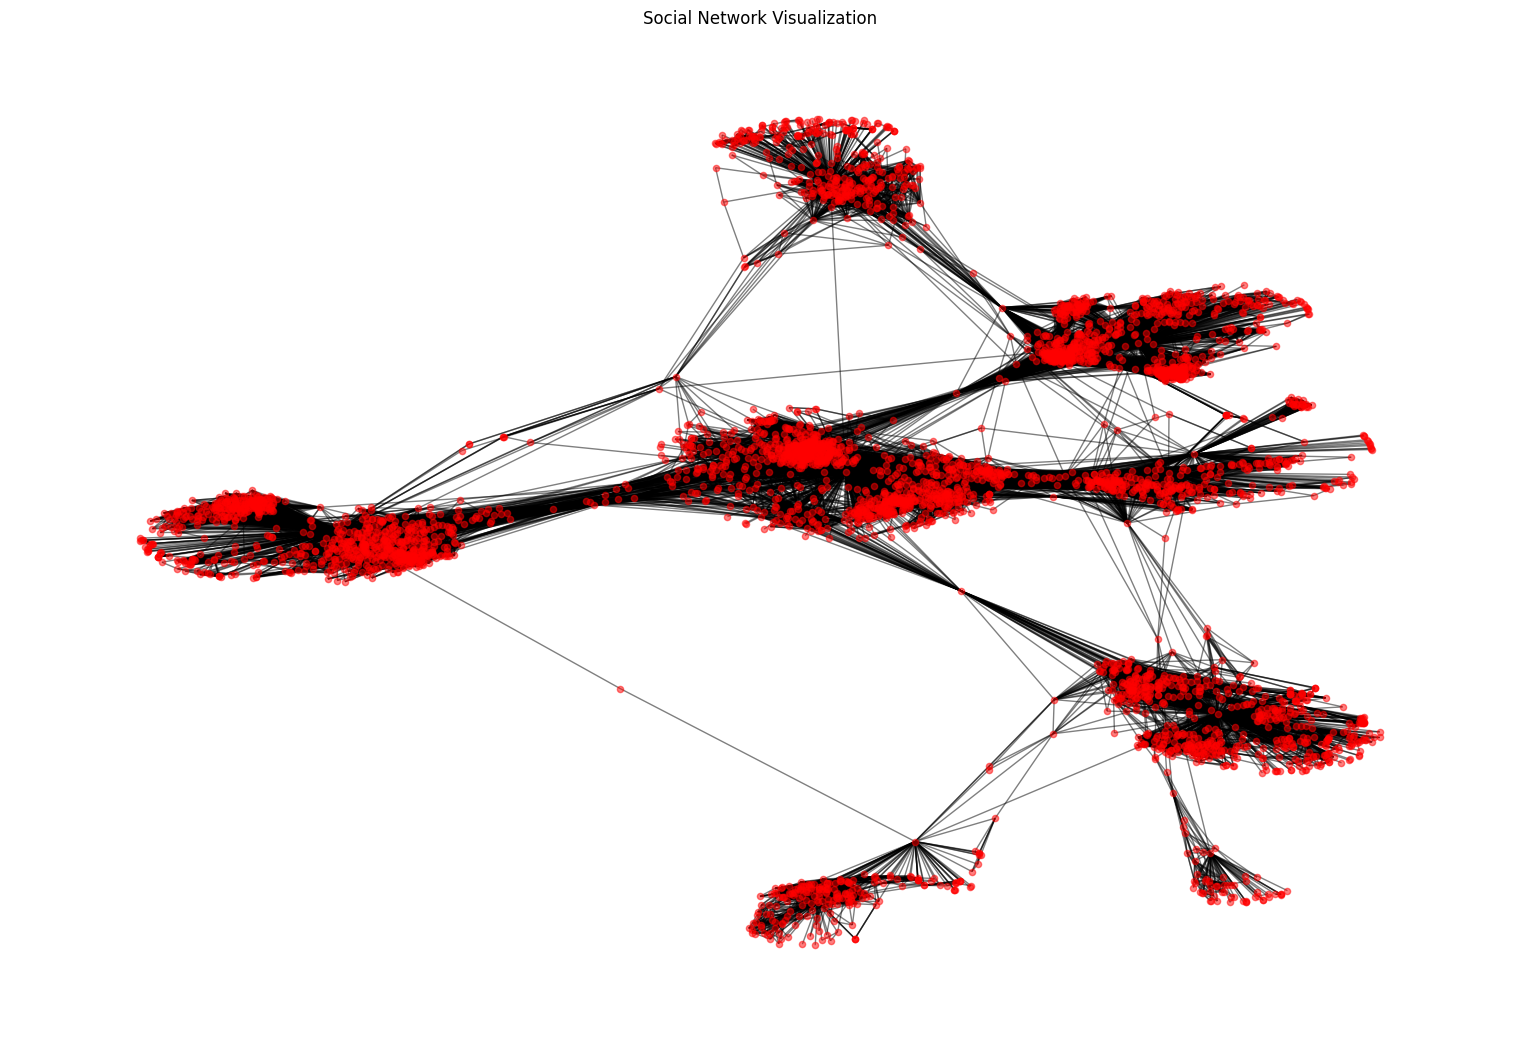

In [80]:
#Create a graph from the edges
G = nx.Graph()
G.add_edges_from(edges)

#Basic visualization of the social network
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, node_size=20, node_color='red', alpha=0.5)
plt.title('Social Network Visualization')
plt.savefig('Social Network Visualization', dpi=300, bbox_inches='tight')
plt.show()

In [81]:
# Basic network characteristics
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes  # average degree

# Print network characteristics
print(f'Number of nodes: {num_nodes}')
print(f'Number of edges: {num_edges}')
print(f'Network density: {density}')
print(f'Average degree: {avg_degree}')

Number of nodes: 4039
Number of edges: 88234
Network density: 0.010819963503439287
Average degree: 43.69101262688784


# 9) Calculate the edge centrality of this network and plot the distribution of the edge centrality values.

In [82]:
# Calculate Edge Betweenness Centrality
edge_betweenness = nx.edge_betweenness_centrality(G)
# Get the edge centrality values
centrality_values = list(edge_betweenness.values())

In [83]:
centrality_values[:5]

[0.00040049937955461345,
 0.0004923848145417046,
 0.0004287786850298508,
 0.000494007105805077,
 0.0004102707367255275]

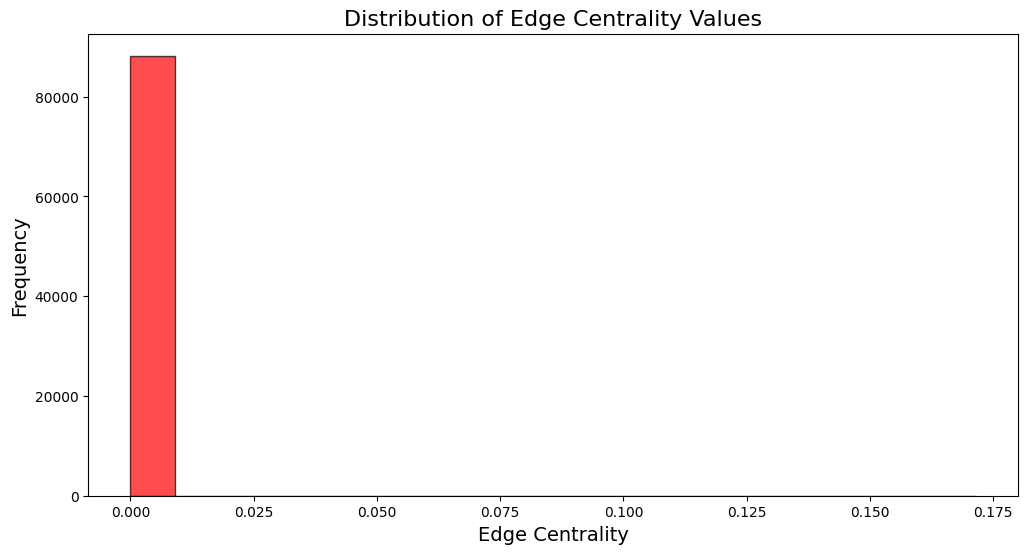

In [101]:
plt.figure(figsize=(12, 6))

# Reduce the number of bins to increase bar thickness
bins = np.linspace(0, max(centrality_values), 20)  # Adjust to a smaller number of bins

plt.hist(centrality_values, bins=bins, color='red', edgecolor='black', alpha=0.7)
plt.title('Distribution of Edge Centrality Values', fontsize=16)
plt.xlabel('Edge Centrality', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Save the plot
plt.savefig('Edge_Centrality_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()


In [86]:
# Check min, max, and some percentiles of edge centrality
print(f"Min edge centrality: {min(centrality_values)}")
print(f"Max edge centrality: {max(centrality_values)}")
print(f"25th percentile: {np.percentile(centrality_values, 25)}")
print(f"50th percentile (median): {np.percentile(centrality_values, 50)}")
print(f"75th percentile: {np.percentile(centrality_values, 75)}")

Min edge centrality: 1.2262805158373514e-07
Max edge centrality: 0.17149343710907303
25th percentile: 4.2980953449294074e-07
50th percentile (median): 8.39224614792378e-07
75th percentile: 2.6307160014748246e-06


Most edges in the network have very low betweenness centrality value. This is typical for networks with a large number of edges, where only a few edges are critical for connecting different parts of the network.
The histogram is highly skewed to the right, with a long tail. This suggests that a few edges have disproportionately high betweenness centrality values, making them much more important than the majority

# 10. Use two community detection algorithms to detect the clusters/community within this social network, then compare the difference of results (the number of clusters and numbers of nodes in each cluster).

## Community Detection using Louvain & Label Propagation

In [87]:
algorithms = [ "Louvain Modularity", "Label Propagation"]

# Dictionary to store communities detected by each algorithm
detected_communities = {}

# Apply each community detection algorithm and store the detected communities
for algorithm in algorithms:
    if algorithm == "Louvain Modularity":
        communities = nx.algorithms.community.greedy_modularity_communities(G)
    elif algorithm == "Label Propagation":
        communities = nx.algorithms.community.label_propagation_communities(G)
    detected_communities[algorithm] = communities
print ('community detection done')

community detection done


## Comparison

In [88]:
from statistics import mean
# Evaluate and compare the results
for algorithm, communities in detected_communities.items():
    modularity = nx.algorithms.community.modularity(G, communities)
    num_communities = len(communities)
    community_sizes = [len(community) for community in communities]
    average_community_size = average_community_size = mean(community_sizes)
    
    print(f"{algorithm}:")
    print(f"Modularity: {modularity}")
    print(f"Number of Communities: {num_communities}")
    print(f"Community Sizes: {community_sizes}")
    print(f"Average Community Size: {average_community_size}\n")

Louvain Modularity:
Modularity: 0.7773775199040279
Number of Communities: 13
Community Sizes: [983, 815, 548, 543, 372, 219, 208, 206, 59, 37, 25, 18, 6]
Average Community Size: 310.6923076923077

Label Propagation:
Modularity: 0.7368407345348215
Number of Communities: 44
Community Sizes: [198, 36, 10, 8, 8, 34, 2, 215, 16, 3, 3, 1030, 6, 7, 3, 3, 753, 10, 2, 2, 469, 13, 9, 3, 49, 25, 2, 60, 547, 179, 10, 9, 8, 226, 19, 4, 3, 8, 6, 14, 12, 7, 6, 2]
Average Community Size: 91.79545454545455



## Visualization

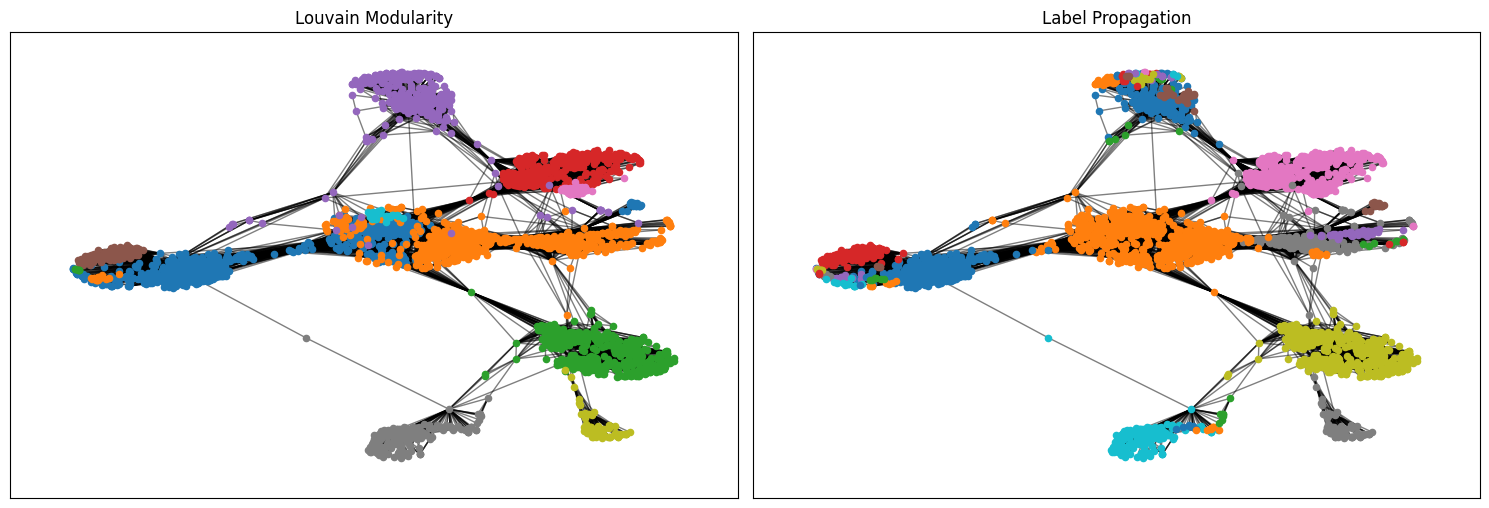

In [89]:
# Visualize community structures
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, seed=42)
for i, (algorithm, communities) in enumerate(detected_communities.items()):
    plt.subplot(2, 2, i+1)
    colors = [f'C{i}' for i in range(len(communities))]
    for j, community in enumerate(communities):
        nx.draw_networkx_nodes(G, pos, nodelist=community, node_color=colors[j], node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.title(algorithm)
plt.tight_layout()
plt.savefig("Comparison of Models", dpi=300, bbox_inches='tight')
plt.show()

# FIN!